## Since iron & myelin IQR/std need to be computed from the raw data, we need to re-combine everything

In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import os
import glob
import statsmodels.api as sm
from statsmodels.stats import outliers_influence
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
### 1. Demographics (for sex/age)

In [34]:
demo = pd.read_csv('../data/source_data/ahead_demographics.csv', sep=';')
demo = demo.loc[pd.notnull(demo['ScanName'])]
demo['Segmentation'] = demo['ScanName'].apply(lambda x: 'sub-' + x[-3:])
demo.head()

ScanName Sexe Group   Age Segmentation
0  Subcortex_0000    f    1F  22.0      sub-000
1  Subcortex_0001    m    1M  23.0      sub-001
2  Subcortex_0002    f    1F  25.0      sub-002
3  Subcortex_0003    f    1F  23.0      sub-003
4  Subcortex_0004    f    1F  23.0      sub-004

### 2. Intracranial volume (ICV) estimates

In [35]:
icv = pd.read_csv('../data/source_data/ahead-qmr2-icv-statistics.csv')
del icv['Template']
del icv['Intensity']
icv['Segmentation'] = icv['Segmentation'].apply(lambda x: x.split('_')[0])
whole_brain_volume = icv.rename(columns={'Label_1': 'icv'})

### 3. Cortex statistics
We need to merge five files:
1. source_data/qmri-cruise-cortex-final-statistics.csv, which contains the volumes and thickness, as well as an older version of the qMRI statistics (with a clipping issue)
2. source_data/qmri-cruise-cortex-r1hz/r2hz/qpd/qsm-wb2-statistics.csv, which contain the qMRI values (after clipping issue was resolved)

In [36]:
def split_intensity_name(x):
    if 'thick' in x:
        return 'thickness'
    if 'iron' in  x:
        return 'iron'
    if 'myelin' in x:
        return 'myelin'
    else:
        return x.split('_')[3].split('-')[1]

# old values: use to extract 'thickness' and 'seg' from intensity
cortical = pd.read_csv('../data/source_data/qmri2-cruise-cortex-final-statistics.csv')
cortical = cortical.loc[cortical['Segmentation'].apply(lambda x: 'sub-' in x and '.nii.gz' in x)]
cortical = cortical.loc[cortical['Intensity'].apply(lambda x: ('sub-' in x and '.nii.gz' in x) or (x=='-'))]

cortical['ROI'] = cortical['Segmentation'].apply(lambda x: x.split('_')[1])
cortical['Segmentation'] = cortical['Segmentation'].apply(lambda x: x.split('_')[0])
cortical.Intensity = cortical.Intensity.replace({'-': 'sub-xxx_ses-x_acq-xx_mod-seg_std_brain'})  # just a trick
cortical.Intensity = cortical.Intensity.apply(split_intensity_name)

# remove qMRI-values from first file
cortical = cortical.loc[cortical.Intensity.isin(['seg', 'thickness'])]

# get qMRi-values
all_csvs = sorted(glob.glob('../data/source_data/qmri2-cruise-cortex-*wb2-statistics.csv'))
#all_csvs = [x for x in all_csvs if not 'iron' in x and not 'myelin' in x]  # NB these csvs are created after notebook 2
qmri_values_cruise = []
for csv in all_csvs:
    qmri_values_cruise.append(pd.read_csv(csv))
qmri_values_cruise = pd.concat(qmri_values_cruise)
qmri_values_cruise = qmri_values_cruise.loc[qmri_values_cruise['Segmentation'].apply(lambda x: 'sub-' in x and '.nii.gz' in x)]
qmri_values_cruise = qmri_values_cruise.loc[qmri_values_cruise['Intensity'].apply(lambda x: ('sub-' in x and '.nii.gz' in x) or (x=='-'))]

qmri_values_cruise['ROI'] = qmri_values_cruise['Segmentation'].apply(lambda x: x.split('_')[1])
qmri_values_cruise['Segmentation'] = qmri_values_cruise['Segmentation'].apply(lambda x: x.split('_')[0])
qmri_values_cruise.Intensity = qmri_values_cruise.Intensity.apply(split_intensity_name)

# merge, clean-up
cortical = pd.concat([cortical, qmri_values_cruise])
cortical.columns = ['Measure', 'Segmentation', 'Template', 'Intensity', 'GM', 'WM_and_subcortex', 'ROI']
cortical_wide = cortical.pivot_table(values='GM', index=['Measure', 'Segmentation', 'Template', 'Intensity'], columns='ROI').reset_index()
del cortical_wide['Template']
cortical_wide = cortical_wide.rename(columns={'cb': "Cerebellum", 'lcr': 'Cortex L', 'rcr': 'Cortex R'})
#cortical_wide.to_csv('interim_data/CRUISE_combined.csv')

### 4. qMRI metrics subcortex

In [47]:
all_csvs = sorted(glob.glob('../data/source_data/ahead-31struct-qmri2fcm-*-statistics.csv'))
#all_csvs = [x for x in all_csvs if not 'iron' in x and not 'myelin' in x]  # NB these csvs are created after notebook 2
data = []
for csv in all_csvs:
    this_csv = pd.read_csv(csv)
    
    if 'seg' in csv:
        this_csv = this_csv.loc[this_csv.Measure == 'Voxels']
        tmp = this_csv.copy()
        tmp.Measure = 'Volume'

        # to volume in mm3
        for x in np.arange(1, 32, dtype=int):
            tmp['Label_'+str(x)] = tmp['Label_'+str(x)] * (0.64*0.64*0.7)
        this_csv = pd.concat([this_csv, tmp])
        
    this_csv['Intensity'] = csv.split('-')[-2]
    data.append(this_csv)
    
data = pd.concat(data)
col_names = ['STR L', 'STR R',
             'STN L', 'STN R',
             'SN L', 'SN R',
             'RN L', 'RN R',
             'GPi L', 'GPi R',
             'GPe L', 'GPe R',
             'THA L', 'THA R',
             'LV L', 'LV R',
             '3V', '4V',
             'AMG L', 'AMG R',
             'ic L', 'ic R',
             'VTA L', 'VTA R',
             'fx',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'CL L', 'CL R']
# col_names_orig = list(pd.read_csv('./old_data_not_denoised/ahead-35struct-simple-statistics-edited.csv').columns[3:-1])
# col_names = [x for x in col_names_orig if not 'ICO ' in x and not 'SCO ' in x]  # ICO & SCO were dropped due to poor segmentation performance

In [48]:
data

Measure                                      Segmentation Template  \
0    CenterOfMassX  sub-000_ses-1_tim_massp-label_def-img_out.nii.gz        -   
1    CenterOfMassX  sub-001_ses-1_tim_massp-label_def-img_out.nii.gz        -   
2    CenterOfMassX  sub-002_ses-1_tim_massp-label_def-img_out.nii.gz        -   
3    CenterOfMassX  sub-003_ses-1_tim_massp-label_def-img_out.nii.gz        -   
4    CenterOfMassX  sub-004_ses-1_tim_massp-label_def-img_out.nii.gz        -   
..             ...                                               ...      ...   
100         Volume          sub-105_ses-1_tim_massp-label_out.nii.gz        -   
101         Volume          sub-106_ses-1_tim_massp-label_out.nii.gz        -   
102         Volume          sub-107_ses-1_tim_massp-label_out.nii.gz        -   
103         Volume          sub-108_ses-1_tim_massp-label_out.nii.gz        -   
104         Volume          sub-109_ses-1_tim_massp-label_out.nii.gz        -   

    Intensity      Label_1      Label_2    Label_3    Label_4    Label_5  \
0    location    155.07576    232.31755  174.90361  214.52430  175.98135   
1    location    154.84969    234.15355  176.51344  215.81720  178.44713   
2    location    151.86940    237.64330  172.46976  217.77620  174.67136   
3    location    151.72502    237.91682  169.88448  217.65997  176.57689   
4    location    152.82648    238.44600  172.80309  218.16006  174.89891   
..        ...          ...          ...        ...        ...        ...   
100       seg   9990.18496   9559.53152   87.16288   66.23232  569.42592   
101       seg  12715.17184  12464.00512  130.74432  116.69504  627.63008   
102       seg  10955.57120  10981.37600  111.24736   80.28160  652.57472   
103       seg   9105.94048   8906.09664   76.84096   66.51904  422.33856   
104       seg  10889.33888  10634.44480   91.17696   79.99488  500.03968   

       Label_6  ...    Label_22   Label_23   Label_24    Label_25   Label_26  \
0    214.76796  ...   230.94461  189.40000  203.03912   196.70505  192.06961   
1    213.52888  ...   233.47780  189.63411  203.43079   192.96661  193.25697   
2    215.49118  ...   234.43922  187.51788  204.28055   198.28828  191.65907   
3    215.50954  ...   235.00879  187.80951  204.23775   187.33324  190.39275   
4    214.70152  ...   237.24324  186.90572  204.35884   192.31350  190.62299   
..         ...  ...         ...        ...        ...         ...        ...   
100  556.52352  ...  3660.84096  325.14048  323.13344  1274.47040  225.07520   
101  593.22368  ...  3936.09216  334.31552  372.16256  2104.23808  256.61440   
102  629.35040  ...  3790.72512  357.53984  391.37280  1503.84640  247.72608   
103  401.40800  ...  3487.66208  327.72096  345.78432  1755.58656  267.50976   
104  502.04672  ...  3637.90336  377.32352  394.52672  1673.58464  232.52992   

      Label_27   Label_28   Label_29     Label_30   Label_31  
0    199.21844  180.97862  212.03920   126.690025  262.26240  
1    200.65909  181.76802  211.35835   127.691986  264.00600  
2    199.53023  180.04979  210.38416   122.949680  268.01395  
3    198.09903  178.58186  210.99190   120.778850  268.74094  
4    199.24384  178.65425  211.83113   120.290930  271.03635  
..         ...        ...        ...          ...        ...  
100  203.28448  164.29056  174.32576  1018.716160  875.92960  
101  259.19488  215.04000  227.65568  1111.900160  989.75744  
102  236.83072  189.23520  199.84384  1191.895040  980.00896  
103  276.68480  199.84384  235.39712   962.232320  865.32096  
104  243.13856  185.79456  233.67680  1014.702080  998.93248  

[2100 rows x 35 columns]

In [49]:
data.columns = ['Measure', 'Segmentation', 'Template', 'Intensity'] + col_names
data['Segmentation'] = data['Segmentation'].apply(lambda x: x.split('_')[0])
data = data.loc[data['Segmentation'] != 'sub-070']  # subject was dropped due to data quality issues
del data['Template']

# merge subcortex data with demographics
data = pd.merge(data, demo[['Sexe', 'Age', 'Segmentation']], on='Segmentation')
data = data.sort_values(['Measure', 'Segmentation', 'Intensity'])
data.head()

# coerce to float
for col in col_names:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#data.to_csv('./final_data/AHEAD-wide-combined.csv')

# merge Ahead with cortex data

In [52]:
data = pd.merge(data, cortical_wide, how='outer')
col_names += ['Cerebellum', 'Cortex L', 'Cortex R']

# correct qpd
# qpd_idx = data['Intensity'] == 'qpd'
# def mean_notnull(x):
#     return x[x>0].mean()

# ## Correct QPD by referencing to (mean across ventricles) ventricle-value
# mean_qpd = data.loc[qpd_idx][['VENT R', 'VENT L', 'VENT 3', 'VENT 4']].apply(mean_notnull, 1)
# data.loc[qpd_idx, col_names] /= np.tile(mean_qpd[:,np.newaxis], (1, len(col_names)))
# data.loc[(qpd_idx)]

data.head()
#data.to_csv('./final_data/AHEAD_and_CRUISE-wide-combined-qpdcorrected.csv')

Measure Segmentation Intensity      STR L      STR R      STN L  \
0  CenterOfMassX      sub-000  location  155.07576  232.31755  174.90361   
1  CenterOfMassX      sub-001  location  154.84969  234.15355  176.51344   
2  CenterOfMassX      sub-002  location  151.86940  237.64330  172.46976   
3  CenterOfMassX      sub-003  location  151.72502  237.91682  169.88448   
4  CenterOfMassX      sub-004  location  152.82648  238.44600  172.80309   

       STN R       SN L       SN R       RN L  ...      PAG R      PPN L  \
0  214.52430  175.98135  214.76796  185.39087  ...  199.21844  180.97862   
1  215.81720  178.44713  213.52888  186.53973  ...  200.65909  181.76802   
2  217.77620  174.67136  215.49118  183.98245  ...  199.53023  180.04979   
3  217.65997  176.57689  215.50954  184.56683  ...  198.09903  178.58186   
4  218.16006  174.89891  214.70152  184.52159  ...  199.24384  178.65425   

       PPN R        CL L       CL R  Sexe   Age  Cerebellum  Cortex L  \
0  212.03920  126.690025  262.26240     f  22.0         NaN       NaN   
1  211.35835  127.691986  264.00600     m  23.0         NaN       NaN   
2  210.38416  122.949680  268.01395     f  25.0         NaN       NaN   
3  210.99190  120.778850  268.74094     f  23.0         NaN       NaN   
4  211.83113  120.290930  271.03635     f  23.0         NaN       NaN   

   Cortex R  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

[5 rows x 39 columns]

## Merge with ICV

In [53]:
# icv = pd.read_csv('./ahead-qmr2-icv-statistics.csv')
# del icv['Template']
# del icv['Intensity']
# icv['Segmentation'] = icv['Segmentation'].apply(lambda x: x.split('_')[0])
# whole_brain_volume = icv.rename(columns={'Label_1': 'icv'})

ahead = pd.merge(data, whole_brain_volume.loc[whole_brain_volume.Measure=='Volume',['Segmentation', 'icv']])

In [54]:
## To long format

# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in ahead.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    ahead[col] = ahead[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = ahead.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe', 'icv'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
# ahead_long.loc['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])

ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPi': 'GM',
                                                    'GPe': 'GM',
                                                    'THA': 'GM',
                                                    'LV': 'CSF',
                                                    'AMG': 'GM',
                                                    'ic': 'WM',
                                                    'VTA': 'GM',
                                                    'fx': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

Intensity        Measure Segmentation   Age Sexe        icv    ROI  \
0  location  CenterOfMassX      sub-000  22.0    f  1408505.6  STR L   
1  location  CenterOfMassY      sub-000  22.0    f  1408505.6  STR L   
2  location  CenterOfMassZ      sub-000  22.0    f  1408505.6  STR L   
3      iron  IQR_intensity      sub-000  22.0    f  1408505.6  STR L   
4    myelin  IQR_intensity      sub-000  22.0    f  1408505.6  STR L   

        Value ROI2 hemisphere tissue_type  
0  155.075760  STR          L          GM  
1  185.431760  STR          L          GM  
2  152.403210  STR          L          GM  
3    3.993294  STR          L          GM  
4    2.239665  STR          L          GM

In [56]:
# save
ahead_long.to_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv', index=False)

In [61]:
# ahead_long.ROI.unique()

In [62]:
# # Restructure
# ahead_wide = ahead_long.pivot_table(values='Value', index=['Segmentation', 'Measure', 'Age', 'Sexe', 'ROI', 'ROI2', 'hemisphere', 'tissue_type', 'icv'], columns='Intensity')
# ahead_wide = ahead_wide.reset_index()

# # Calculate IQR relative to median values
# tmp = ahead_wide.copy()
# tmp2 = tmp.loc[tmp['Measure'] == 'IQR_intensity'].copy()
# cols  = ['iron', 'myelin', 'qpd', 'qsm', 'r1hz', 'r2hz', 'thickness']
# tmp2[cols] = tmp2[cols] / np.abs(tmp.loc[tmp['Measure'] == 'Median_intensity', cols].values)
# tmp2['Measure'] = 'IQR_relative_to_median'
# ahead_wide = pd.concat([ahead_wide, tmp2])

# # long again
# ahead_long = ahead_wide.reset_index().melt(id_vars=['Measure', "Segmentation", 'Age', 'Sexe', 'ROI', 'ROI2', 'hemisphere', 'icv'],
#                                            value_vars=['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'thickness'], value_name='Value', var_name='Intensity')

# ahead_long

In [20]:
# # save
# ahead_long.to_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv', index=False)

In [16]:
with pd.option_context('display.max_rows', 100000):
    display(ahead_long.loc[(ahead_long.Measure=='IQR_relative_to_median')&(ahead_long.Intensity=='r2hz')&(ahead_long.ROI2=='VENT')])

Empty DataFrame
Columns: [Measure, Segmentation, Age, Sexe, ROI, ROI2, hemisphere, icv, Intensity, Value]
Index: []

In [17]:
with pd.option_context('display.max_rows', 100000):
    display(ahead_long.loc[(ahead_long.Measure=='Median_intensity')&(ahead_long.Intensity=='r2hz')&(ahead_long.ROI2=='VENT')])

Empty DataFrame
Columns: [Measure, Segmentation, Age, Sexe, ROI, ROI2, hemisphere, icv, Intensity, Value]
Index: []

In [ ]:
with pd.option_context('display.max_rows', 100000):
    display(ahead_long.loc[(ahead_long.Measure=='Median_intensity')&(ahead_long.Intensity=='r2hz')&(ahead_long.ROI2=='VENT')])

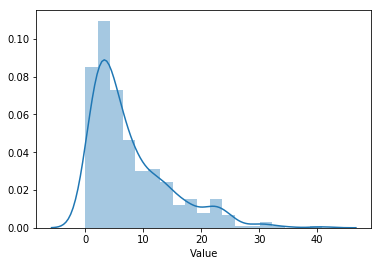

In [33]:
sns.distplot(ahead_long.loc[(ahead_long.Measure=='Median_intensity')&(ahead_long.Intensity=='r2hz')&(ahead_long.ROI2=='VENT'),'Value'])

## Checks: Any correlations with ICV?


In [10]:
icv = whole_brain_volume.copy()
icv = icv.loc[icv['Measure'] == 'Volume']

In [11]:
tmp = data.loc[(data['Measure'] == "Median_intensity")]
# icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Voxels")].iloc[:,3:-3].sum(1), columns=['icv'])

col_names_no_ventricles = [x for x in col_names if not 'VENT' in x]
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    this_data = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == modality), col_names_no_ventricles]
    icv[modality] = this_data.mean(1).values

sns.heatmap(icv.corr(), annot=True)
sns.pairplot(icv)

for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    print(scipy.stats.pearsonr(icv['icv'], icv[modality]))

ValueError: Length of values does not match length of index

## first take median per ROI (collapse across hemisphere)

(0.06168070426640453, 0.5319258284034409)
(-0.14905271603069087, 0.12912949758004108)
(-0.04354852194153731, 0.6591353719296436)
(0.0635004026488112, 0.5198695925920602)


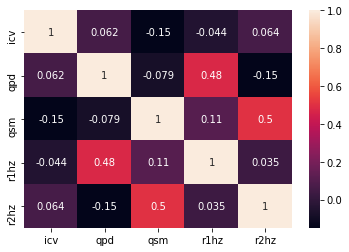

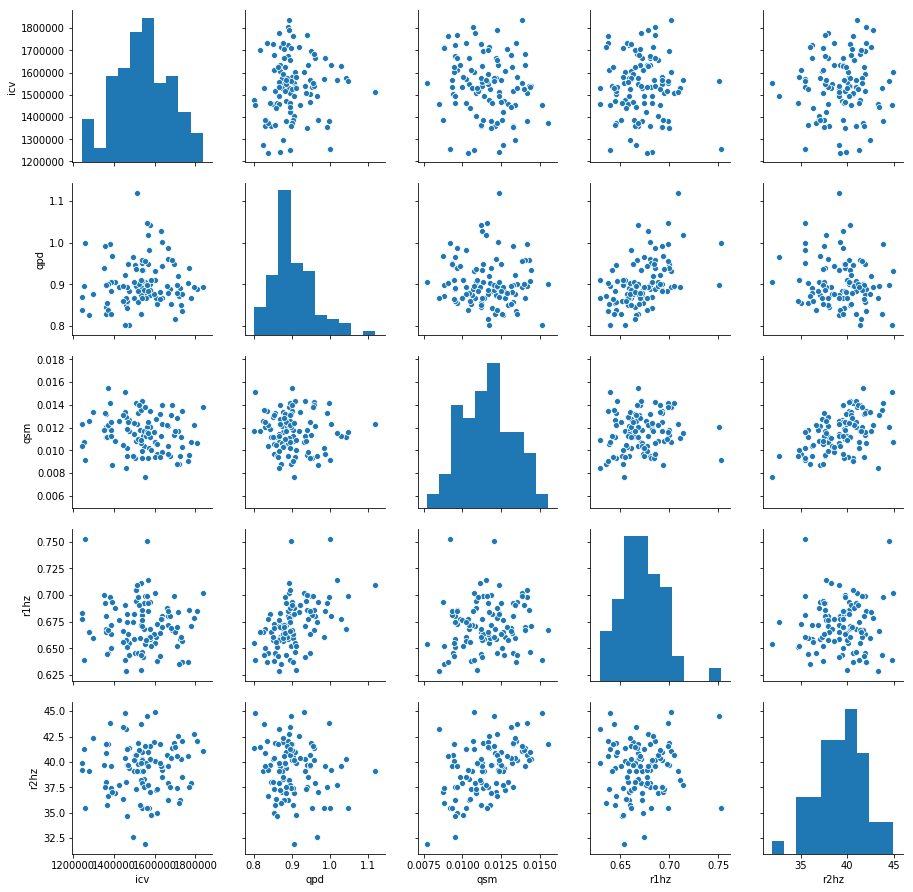

In [12]:
tmp = data.loc[(data['Measure'] == "Median_intensity")].melt(id_vars=['Measure', 'Segmentation', 'Intensity', 'Sexe', 'Age'], var_name='ROI')
tmp['ROI2'] = tmp['ROI'].apply(lambda x: x[:-2] if x.endswith(' L') or x.endswith(' R') else x)
tmp = tmp.pivot_table(values='value', index=['Measure', 'Segmentation', 'Intensity'], columns='ROI2').reset_index()
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd')].iloc[:,3:]


icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume")].iloc[:,3:-3].sum(1), columns=['icv'])
icv['Segmentation'] = corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume"), 'Segmentation'].values
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    this_data = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == modality)].iloc[:,3:]
    icv[modality] = this_data.mean(1).values
    
sns.heatmap(icv.corr(), annot=True)
sns.pairplot(icv)
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    print(scipy.stats.pearsonr(icv['icv'], icv[modality]))

## So there is a small but significant negative correlation between R1 and ICV

This is a bit unfortunate - it can cause apparent between-sex differences in R1 (also QPD) measures, which will consequently leak into the myelin estimates. So we'll need to correct for this

What happens if we remove the potential influental data points?

(-0.5291238311111975, 2.1288313876985712e-08)
(-0.1979567602804485, 0.050711839959677894)
(-0.19000874153988917, 0.06093501326389986)
(0.08515274418019347, 0.4044675292644663)


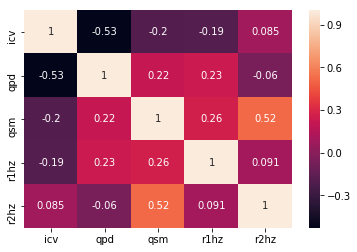

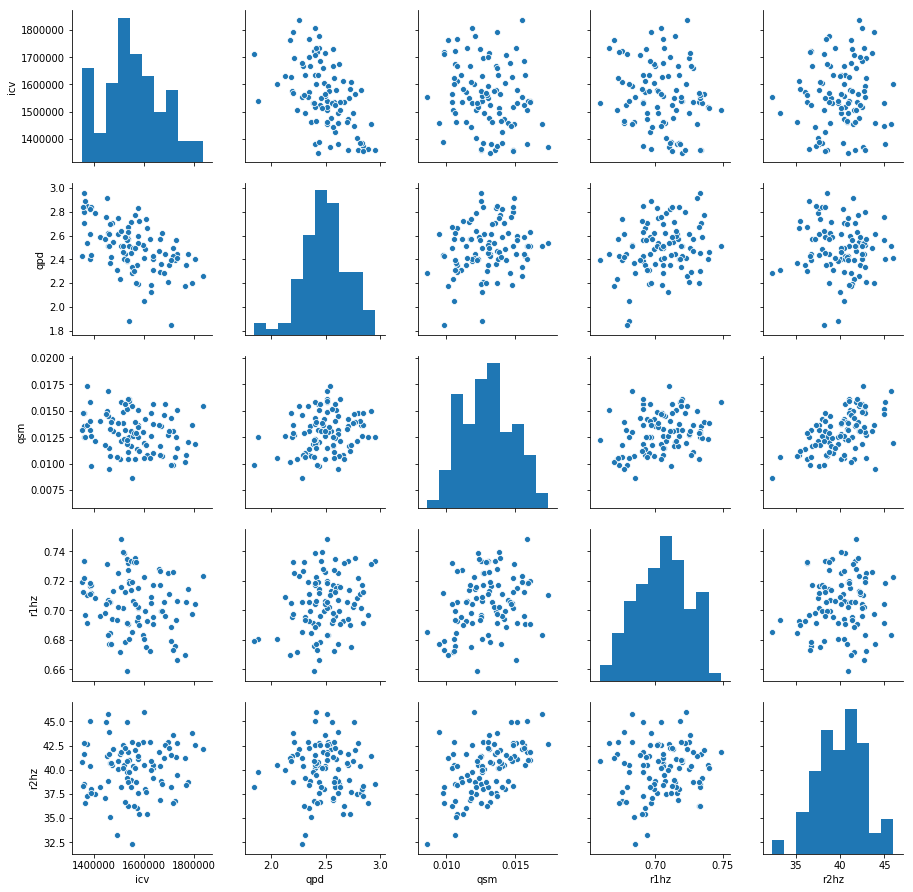

In [67]:
##
icv3 = icv.loc[(icv.icv>1.3e6) & (icv.r1hz <.75)]
sns.heatmap(icv3.corr(), annot=True)
sns.pairplot(icv3)
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    print(scipy.stats.pearsonr(icv3['icv'], icv3[modality]))

In [499]:
## Not so significant anymore, yet still pretty close..

(-0.12650553721821653, 0.20289575762255016)
(-0.18527194775216824, 0.06098382582959798)
(-0.25375227216535967, 0.009699739731648343)
(0.031452138359524894, 0.7524680312587437)


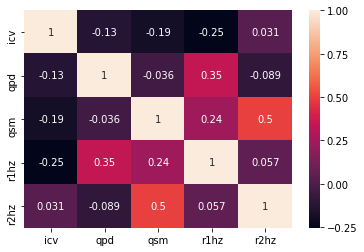

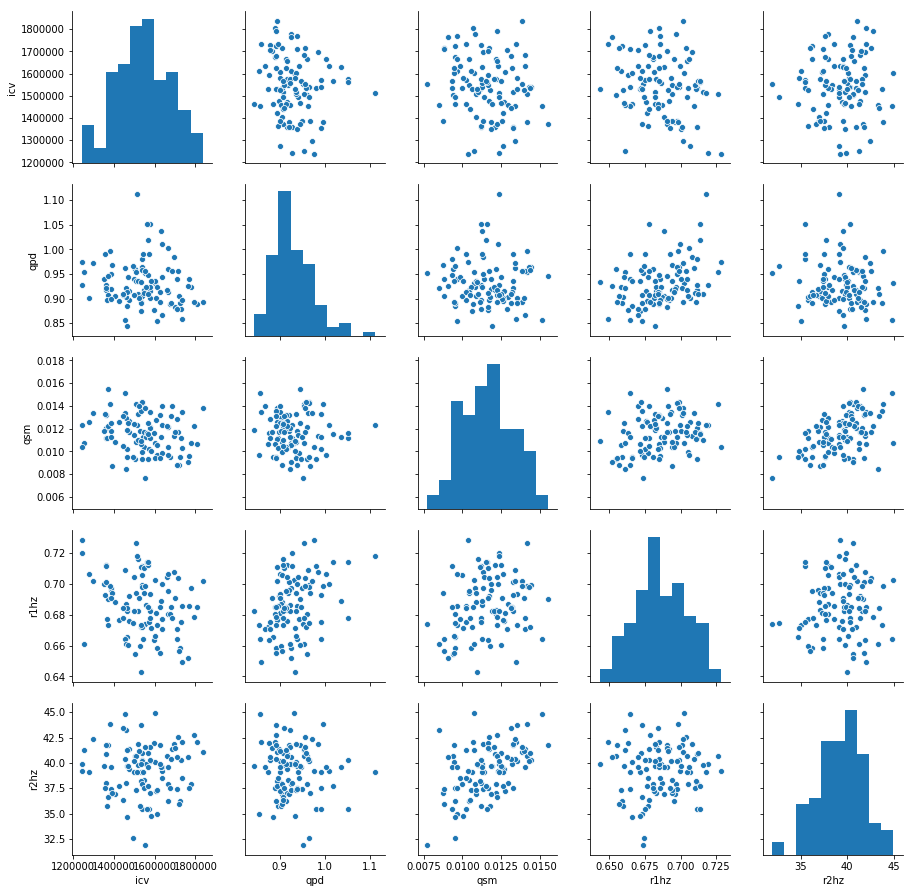

In [500]:
##
icv2 = icv.loc[(icv.r1hz<.75)]
sns.heatmap(icv2.corr(), annot=True)
sns.pairplot(icv2)
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    print(scipy.stats.pearsonr(icv2['icv'], icv2[modality]))

In [68]:
# tmp = corticalMGDM.loc[(corticalMGDM.Measure == 'Volume') & (corticalMGDM.Intensity == '-')]#.iloc[:,3:-2]#.sum(1)
# tmp['icv'] = tmp.iloc[:,3:-2].sum(1)
# tmp[['Age', 'Segmentation']]
# icv = pd.merge(icv, tmp[['Age', 'Segmentation']])

In [69]:
# sns.pairplot(icv, vars=['icv', 'r1hz', 'r2hz', 'qpd', 'qsm'], hue='Age')

In [289]:
# still a correlation

## what about correlations per ROI?

In [70]:
all_cors = []
#icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Voxels")].iloc[:,3:-3].sum(1), columns=['icv'])
icv = whole_brain_volume.copy()
icv = icv.loc[icv.Measure == 'Volume']
for roi in col_names:
    for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        this_data = data.loc[(data['Measure'] == "Median_intensity") & (data['Intensity'] == modality), roi]
        icv[modality] = this_data.values
    
    these_cors = icv.corr().loc['icv']
    these_cors['ROI'] = roi
    all_cors.append(these_cors)
all_cors = pd.concat(all_cors, 1).T

In [71]:
all_cors['qpd'] = all_cors['qpd'].astype(float)
all_cors['qsm'] = all_cors['qsm'].astype(float)
all_cors['r1hz'] = all_cors['r1hz'].astype(float)
all_cors['r2hz'] = all_cors['r2hz'].astype(float)

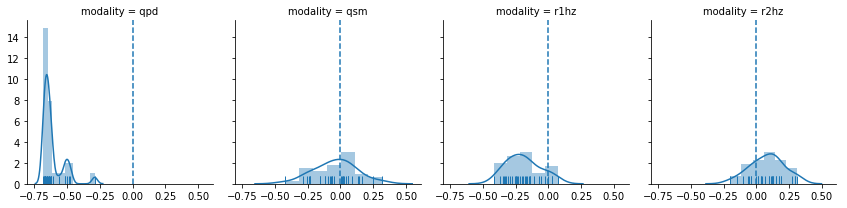

In [72]:
fac = sns.FacetGrid(all_cors.melt(value_vars=['qpd', 'qsm', 'r1hz', 'r2hz'], id_vars=['ROI'], var_name='modality'), col='modality')
fac.map(sns.distplot, 'value', rug=True)
fac.map(plt.axvline, linestyle='--')

## Plot by ROI

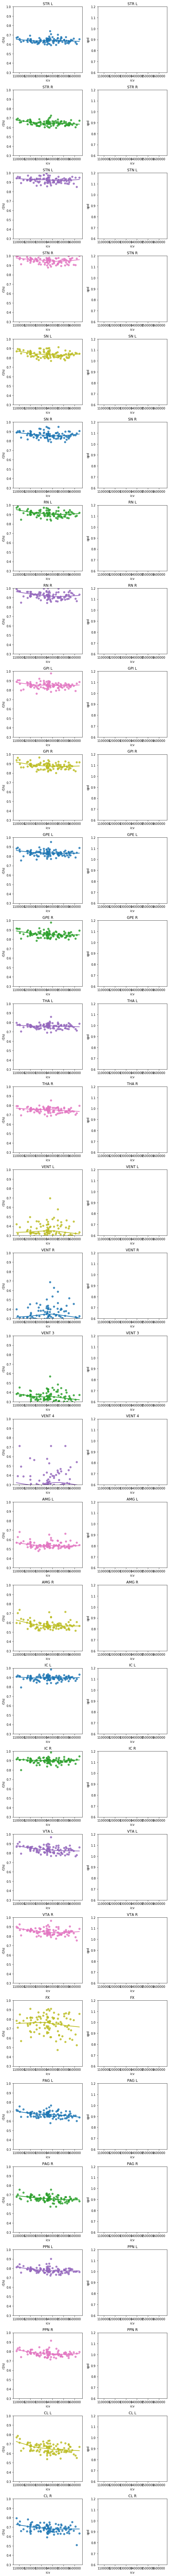

In [73]:
f, ax = plt.subplots(len(col_names), 2)
all_cors = []
icv = whole_brain_volume.copy()
icv = icv.loc[icv.Measure == 'Volume']
for i, roi in enumerate(col_names):
    for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        this_data = data.loc[(data['Measure'] == "Median_intensity") & (data['Intensity'] == modality), roi]
        icv[modality] = this_data.values
    
    sns.regplot(icv['icv'], icv['r1hz'], ax=ax[i,0], lowess=True, truncate=True)
    sns.regplot(icv['icv'], icv['qpd'], ax=ax[i,1], lowess=True, truncate=True)
    ax[i,0].set_title(roi)
    ax[i,1].set_title(roi)
    ax[i,0].set_ylim([0.3, 1])
    ax[i,1].set_ylim([0.6, 1.2])
#    sns.pairplot(icv)

#     these_cors = icv.corr().loc['icv']
#     these_cors['ROI'] = roi
    
#     all_cors.append(these_cors)
# all_cors = pd.concat(all_cors, 1).T

f.set_size_inches(8, 150*.8)
f.tight_layout()

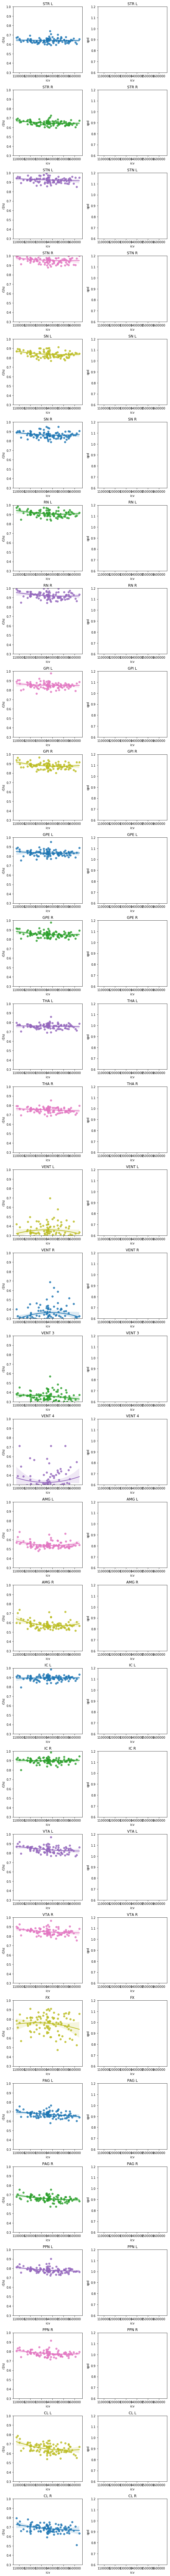

In [74]:
f, ax = plt.subplots(len(col_names), 2)
all_cors = []
icv = whole_brain_volume.copy()
icv = icv.loc[icv.Measure == 'Volume']
for i, roi in enumerate(col_names):
    for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        this_data = data.loc[(data['Measure'] == "Median_intensity") & (data['Intensity'] == modality), roi]
        icv[modality] = this_data.values
    
    sns.regplot(icv['icv'], icv['r1hz'], ax=ax[i,0], order=2, truncate=True)
    sns.regplot(icv['icv'], icv['qpd'], ax=ax[i,1], order=2, truncate=True)
    ax[i,0].set_title(roi)
    ax[i,1].set_title(roi)
    ax[i,0].set_ylim([0.3, 1])
    ax[i,1].set_ylim([0.6, 1.2])
#    sns.pairplot(icv)

#     these_cors = icv.corr().loc['icv']
#     these_cors['ROI'] = roi
    
#     all_cors.append(these_cors)
# all_cors = pd.concat(all_cors, 1).T

f.set_size_inches(8, 150*.8)
f.tight_layout()

## Correct: Make overall R1 ~ ICV and QPD ~ ICV models

In [295]:
tmp = data.loc[(data['Measure'] == "Median_intensity")].melt(id_vars=['Measure', 'Segmentation', 'Intensity', 'Sexe', 'Age'], var_name='ROI')
tmp['ROI2'] = tmp['ROI'].apply(lambda x: x[:-2] if x.endswith(' L') or x.endswith(' R') else x)
tmp = tmp.pivot_table(values='value', index=['Measure', 'Segmentation', 'Intensity'], columns='ROI2').reset_index()
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd')].iloc[:,3:]

icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume")].iloc[:,3:-3].sum(1), columns=['icv'])
icv['Segmentation'] = corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume"), 'Segmentation'].values
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    this_data = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == modality)].iloc[:,3:]
    icv[modality] = this_data.mean(1).values
    

for modality in ['qpd', 'r1hz', 'r2hz', 'qsm']:
    model = sm.OLS(icv[modality], sm.add_constant(icv['icv']))
    res = model.fit()
    display(res.summary())
    
    
    # new qMRI measure is the residual of the model plus the mean ICV effect
    icv[modality + '_corrected'] = res.predict(exog=np.array([1, icv['icv'].mean()]))[0] + (icv[modality] - res.predict())
    icv[modality + '_ratio'] = icv[modality + '_corrected'] / icv[modality]
# from statsmodels.stats.outliers_influence import OLSInfluence
# a = OLSInfluence(res).plot_index()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qpd   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2902
Date:                Thu, 07 May 2020   Prob (F-statistic):              0.591
Time:                        15:36:00   Log-Likelihood:                 162.58
No. Observations:                 105   AIC:                            -321.2
Df Residuals:                     103   BIC:                            -315.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9715      0.059     16.531      0.000       0.855       1.088
icv        -2.048e-08    3.8e-08     -0.539      0.591   -9.58e-08    5.49e-08
==============================================================================
Omnibus:                       40.128   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.601
Skew:                           1.481   Prob(JB):                     2.12e-20
Kurtosis:                       6.455   Cond. No.                     1.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   r1hz   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     8.268
Date:                Thu, 07 May 2020   Prob (F-statistic):            0.00490
Time:                        15:36:00   Log-Likelihood:                 260.52
No. Observations:                 105   AIC:                            -517.0
Df Residuals:                     103   BIC:                            -511.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7540      0.023     32.607      0.000       0.708       0.800
icv          -4.3e-08    1.5e-08     -2.875      0.005   -7.27e-08   -1.33e-08
==============================================================================
Omnibus:                       16.145   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.067
Skew:                           0.694   Prob(JB):                     3.60e-06
Kurtosis:                       4.950   Cond. No.                     1.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   r2hz   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4183
Date:                Thu, 07 May 2020   Prob (F-statistic):              0.519
Time:                        15:36:00   Log-Likelihood:                -246.36
No. Observations:                 105   AIC:                             496.7
Df Residuals:                     103   BIC:                             502.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.4613      2.888     12.972      0.000      31.734      43.189
icv         1.208e-06   1.87e-06      0.647      0.519    -2.5e-06    4.91e-06
==============================================================================
Omnibus:                        1.343   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.511   Jarque-Bera (JB):                1.080
Skew:                          -0.248   Prob(JB):                        0.583
Kurtosis:                       3.040   Cond. No.                     1.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qsm   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.340
Date:                Thu, 07 May 2020   Prob (F-statistic):              0.129
Time:                        15:36:00   Log-Likelihood:                 525.95
No. Observations:                 105   AIC:                            -1048.
Df Residuals:                     103   BIC:                            -1043.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0144      0.002      7.797      0.000       0.011       0.018
icv        -1.826e-09   1.19e-09     -1.530      0.129   -4.19e-09    5.41e-10
==============================================================================
Omnibus:                        2.296   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.584
Skew:                           0.038   Prob(JB):                        0.453
Kurtosis:                       2.403   Cond. No.                     1.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
## apply correction to each ROI individually
data_corrected = data.copy()
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        for measure in data.Measure.unique():
            if measure == 'Volume' or measure == 'Voxels':
                continue
            idx = (data_corrected.Intensity == modality) &\
                  (data_corrected.Measure == measure)
            ratio = icv[modality + '_ratio'].values[:,np.newaxis]
            data_corrected.loc[idx, col_names] *= ratio

## what do the correlations now look like?

(7.165566285229131e-17, 1.0)
(-3.9759399406466684e-16, 1.0)
(1.487287269602822e-15, 1.0)
(-4.1768491898116846e-16, 1.0)


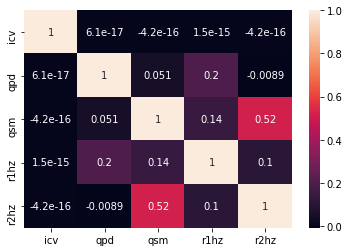

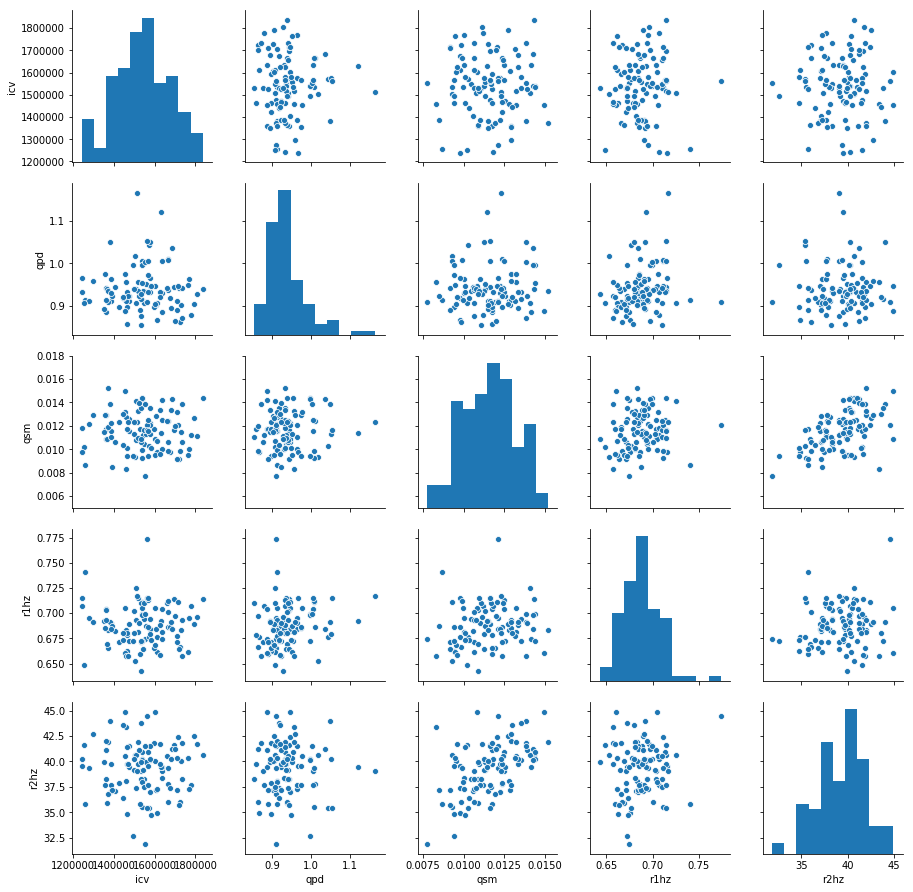

In [297]:
tmp = data_corrected.loc[(data_corrected['Measure'] == "Median_intensity")].melt(id_vars=['Measure', 'Segmentation', 'Intensity', 'Sexe', 'Age'], var_name='ROI')
tmp['ROI2'] = tmp['ROI'].apply(lambda x: x[:-2] if x.endswith(' L') or x.endswith(' R') else x)
tmp = tmp.pivot_table(values='value', index=['Measure', 'Segmentation', 'Intensity'], columns='ROI2').reset_index()
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd')].iloc[:,3:]


icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume")].iloc[:,3:-3].sum(1), columns=['icv'])
icv['Segmentation'] = corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume"), 'Segmentation'].values
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    this_data = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == modality)].iloc[:,3:]
    icv[modality] = this_data.mean(1).values
    
sns.heatmap(icv.corr(), annot=True)
sns.pairplot(icv)
for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
    print(scipy.stats.pearsonr(icv['icv'], icv[modality]))

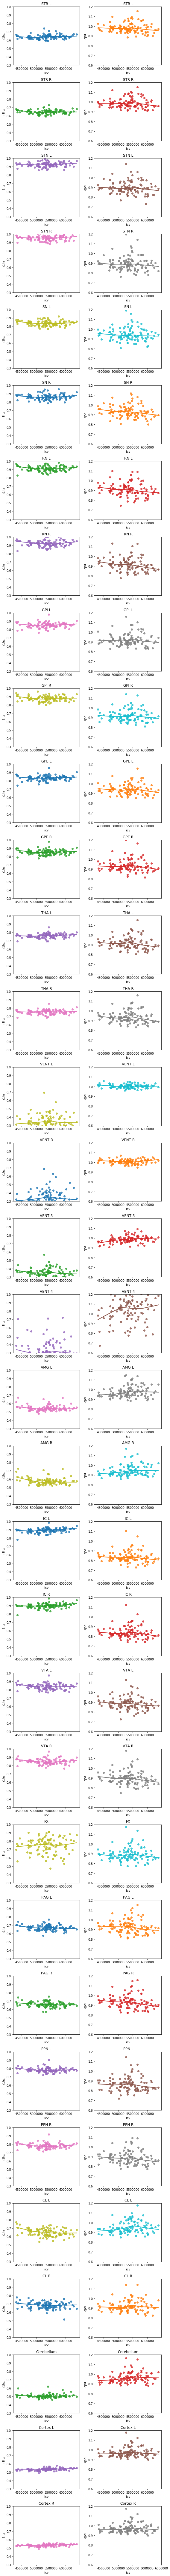

In [298]:
f, ax = plt.subplots(len(col_names), 2)
all_cors = []
icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Voxels")].iloc[:,3:-3].sum(1), columns=['icv'])
for i, roi in enumerate(col_names):
    for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        this_data = data_corrected.loc[(data_corrected['Measure'] == "Median_intensity") & (data_corrected['Intensity'] == modality), roi]
        icv[modality] = this_data.values
    
    sns.regplot(icv['icv'], icv['r1hz'], ax=ax[i,0], lowess=True, truncate=True)
    sns.regplot(icv['icv'], icv['qpd'], ax=ax[i,1], lowess=True, truncate=True)
    ax[i,0].set_title(roi)
    ax[i,1].set_title(roi)
    ax[i,0].set_ylim([0.3, 1])
    ax[i,1].set_ylim([0.6, 1.2])
#    sns.pairplot(icv)

#     these_cors = icv.corr().loc['icv']
#     these_cors['ROI'] = roi
    
#     all_cors.append(these_cors)
# all_cors = pd.concat(all_cors, 1).T

f.set_size_inches(8, 150*.8)
f.tight_layout()

In [299]:
all_cors = []
icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Voxels")].iloc[:,3:-3].sum(1), columns=['icv'])
for roi in col_names:
    for modality in ['qpd', 'qsm', 'r1hz', 'r2hz']:
        this_data = data_corrected.loc[(data_corrected['Measure'] == "Median_intensity") & (data_corrected['Intensity'] == modality), roi]
        icv[modality] = this_data.values
    
    these_cors = icv.corr().loc['icv']
    these_cors['ROI'] = roi
    all_cors.append(these_cors)
all_cors = pd.concat(all_cors, 1).T

all_cors['qpd'] = all_cors['qpd'].astype(float)
all_cors['qsm'] = all_cors['qsm'].astype(float)
all_cors['r1hz'] = all_cors['r1hz'].astype(float)
all_cors['r2hz'] = all_cors['r2hz'].astype(float)

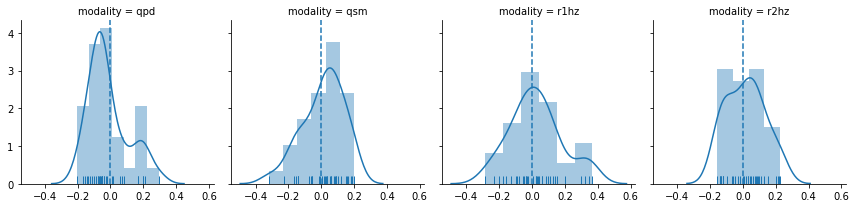

In [300]:
fac = sns.FacetGrid(all_cors.melt(value_vars=['qpd', 'qsm', 'r1hz', 'r2hz'], id_vars=['ROI'], var_name='modality'), col='modality')
fac.map(sns.distplot, 'value', rug=True)
fac.map(plt.axvline, linestyle='--')

In [301]:
data_corrected.to_csv('./AHEAD_and_CRUISE-wide-combined-qpdcorrected-icvcorrected.csv')

## Correct CSF R1 and QPD using thickness as a proxy for B1+ inhomogeneity

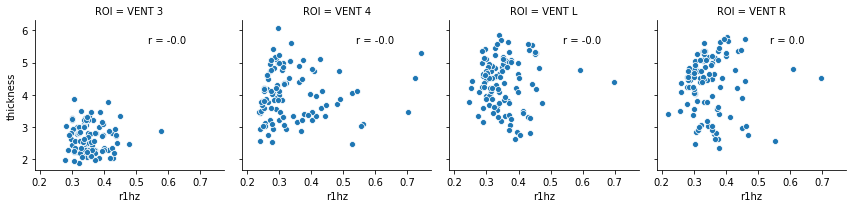

In [474]:
## Plot 
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPI': 'GM',
                                                    'GPE': 'GM',
                                                    'THA': 'GM',
                                                    'VENT': 'CSF',
                                                    'AMG': 'GM',
                                                    'IC': 'WM',
                                                    'VTA': 'GM',
                                                    'FX': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['r1hz', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()

# plot
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'r1hz', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)

#### Per ventricle, estimate R1 and QPD ~ thickness, and remove the variance associated with the thickness

In [448]:
# tmp = data.loc[(data['Measure'] == "Median_intensity")].melt(id_vars=['Measure', 'Segmentation', 'Intensity', 'Sexe', 'Age'], var_name='ROI')
# tmp['ROI2'] = tmp['ROI'].apply(lambda x: x[:-2] if x.endswith(' L') or x.endswith(' R') else x)
# tmp = tmp.pivot_table(values='value', index=['Measure', 'Segmentation', 'Intensity'], columns='ROI').reset_index()

tmp = data
qpd = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
r1hz = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
thickness = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'thickness'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]

qpd_corrected = qpd.copy()
r1hz_corrected = r1hz.copy()

for roi in ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']:
    model = sm.OLS(qpd[roi].reset_index(drop=True), sm.add_constant(thickness[roi].reset_index(drop=True)))
    res = model.fit()
    qpd_corrected[roi] = qpd_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean()])

    model = sm.OLS(r1hz[roi].reset_index(drop=True), sm.add_constant(thickness[roi].reset_index(drop=True)))
    res = model.fit()
    r1hz_corrected[roi] = r1hz_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean()])

# re-insert qpd, r1hz
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = qpd_corrected.iloc[:,1:].values
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = r1hz_corrected.iloc[:,1:].values

# did it work?

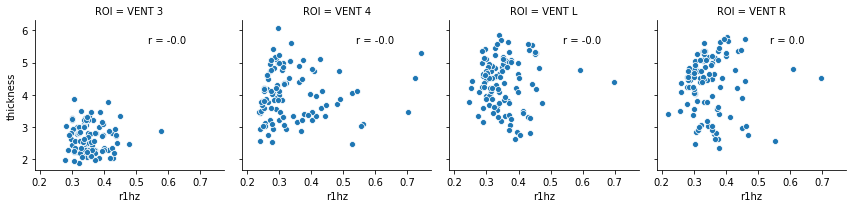

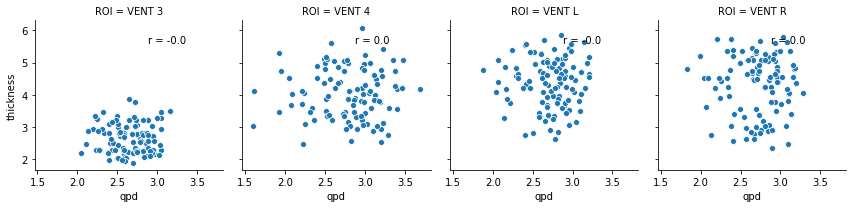

In [471]:
## Plot 
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPI': 'GM',
                                                    'GPE': 'GM',
                                                    'THA': 'GM',
                                                    'VENT': 'CSF',
                                                    'AMG': 'GM',
                                                    'IC': 'WM',
                                                    'VTA': 'GM',
                                                    'FX': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['r1hz', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()

# plot
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'r1hz', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)
    
# qpd
tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['qpd', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()    
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'qpd', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)

In [473]:
## merge with cortical data, save
data = pd.merge(data, cortical_wide, how='outer')
col_names += ['Cerebellum', 'Cortex L', 'Cortex R']

# correct qpd
qpd_idx = data['Intensity'] == 'qpd'
def mean_notnull(x):
    return x[x>0].mean()

## Correct QPD by referencing to (mean across ventricles) ventricle-value
mean_qpd = data.loc[qpd_idx][['VENT R', 'VENT L', 'VENT 3', 'VENT 4']].apply(mean_notnull, 1)
data.loc[qpd_idx, col_names] /= np.tile(mean_qpd[:,np.newaxis], (1, len(col_names)))
data.loc[(qpd_idx)]

data.head()
data.to_csv('./AHEAD_and_CRUISE-wide-combined-qpdcorrected-thickness.csv')

## Regress out both thickness and brain size?


In [11]:
## Regress out both thickness and brain size?
icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume")].iloc[:,3:-3].sum(1), columns=['icv'])
icv['Segmentation'] = corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume"), 'Segmentation'].values

tmp = data
qpd = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
r1hz = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
thickness = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'thickness'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]

qpd_corrected = qpd.copy()
r1hz_corrected = r1hz.copy()

for roi in ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']:
    pred = pd.concat([thickness[roi].reset_index(drop=True), icv['icv'].reset_index(drop=True)], 1)
    model = sm.OLS(qpd[roi].reset_index(drop=True), sm.add_constant(pred))
    res = model.fit()
    qpd_corrected[roi] = qpd_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean(),icv['icv'].mean()])

    model = sm.OLS(r1hz[roi].reset_index(drop=True), sm.add_constant(pred))
    res = model.fit()
    r1hz_corrected[roi] = r1hz_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean(),icv['icv'].mean()])

# re-insert qpd, r1hz
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = qpd_corrected.iloc[:,1:].values
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = r1hz_corrected.iloc[:,1:].values

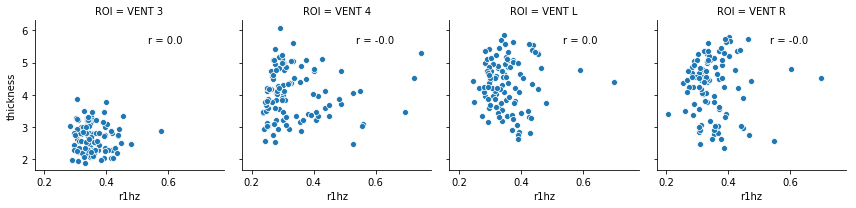

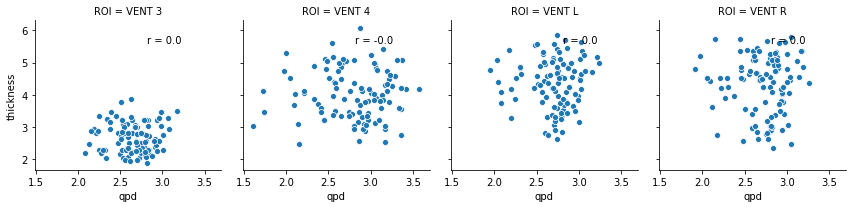

In [23]:
## Plot 
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPI': 'GM',
                                                    'GPE': 'GM',
                                                    'THA': 'GM',
                                                    'VENT': 'CSF',
                                                    'AMG': 'GM',
                                                    'IC': 'WM',
                                                    'VTA': 'GM',
                                                    'FX': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['r1hz', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()

# plot
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'r1hz', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)
    
# qpd
tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['qpd', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()    
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'qpd', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)

In [27]:
## merge with cortical data, save
data = pd.merge(data, cortical_wide, how='outer')
col_names += ['Cerebellum', 'Cortex L', 'Cortex R']

# correct qpd
qpd_idx = data['Intensity'] == 'qpd'
def mean_notnull(x):
    return x[x>0].mean()

## Correct QPD by referencing to (mean across ventricles) ventricle-value
mean_qpd = data.loc[qpd_idx][['VENT R', 'VENT L', 'VENT 3', 'VENT 4']].apply(mean_notnull, 1)
data.loc[qpd_idx, col_names] /= np.tile(mean_qpd[:,np.newaxis], (1, len(col_names)))
data.loc[(qpd_idx)]

data.head()
data.to_csv('./AHEAD_and_CRUISE-wide-combined-qpdcorrected-icvcorrected-thickness.csv')

## Regress out thickness, ICV, and sex differences from CSF

In [76]:
## Regress out both thickness and brain size?
#icv = pd.DataFrame(corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume")].iloc[:,3:-3].sum(1), columns=['icv'])
#icv['Segmentation'] = corticalMGDM.loc[(corticalMGDM['Measure'] == "Volume"), 'Segmentation'].values
icv = whole_brain_volume.copy()
icv = icv.loc[icv.Measure == 'Volume']

tmp = data.copy()
qpd = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
r1hz = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
thickness = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'thickness'), ['Segmentation', 'VENT L', 'VENT R', 'VENT 3', 'VENT 4']]
sexe = tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'thickness'), ['Segmentation', 'Sexe']]

qpd_corrected = qpd.copy()
r1hz_corrected = r1hz.copy()
all_res = []
for roi in ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']:
    pred = pd.concat([thickness[roi].reset_index(drop=True), icv['icv'].reset_index(drop=True), (sexe['Sexe'].reset_index(drop=True)=='m').astype(int)], 1)
#     pred['icv'] = (pred['icv'] - pred['icv'].mean())/pred['icv'].std()
    model = sm.OLS(qpd[roi].reset_index(drop=True), sm.add_constant(pred))
    res = model.fit()
    qpd_corrected[roi] = qpd_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean(),icv['icv'].mean(), 0.5])

    model = sm.OLS(r1hz[roi].reset_index(drop=True), sm.add_constant(pred))
    res = model.fit()
    all_res.append(res)
    r1hz_corrected[roi] = r1hz_corrected[roi] - res.predict() + res.predict([1,thickness[roi].mean(),icv['icv'].mean(), 0.5])

# re-insert qpd, r1hz
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'qpd'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = qpd_corrected.iloc[:,1:].values
tmp.loc[(tmp['Measure'] == "Median_intensity") & (tmp['Intensity'] == 'r1hz'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']] = r1hz_corrected.iloc[:,1:].values

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [84]:
all_res[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 VENT 4   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.032
Date:                Tue, 12 May 2020   Prob (F-statistic):              0.382
Time:                        17:02:19   Log-Likelihood:                 90.776
No. Observations:                 105   AIC:                            -173.6
Df Residuals:                     101   BIC:                            -162.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3590      0.136      2.644      0.009       0.090       0.628
VENT 4        -0.0235      0.014     -1.739      0.085      -0.050       0.003
icv         5.437e-08   1.05e-07      0.516      0.607   -1.55e-07    2.63e-07
Sexe          -0.0058      0.028     -0.210      0.834      -0.060       0.049
==============================================================================
Omnibus:                       53.635   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.847
Skew:                           1.957   Prob(JB):                     9.57e-32
Kurtosis:                       7.162   Cond. No.                     1.85e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

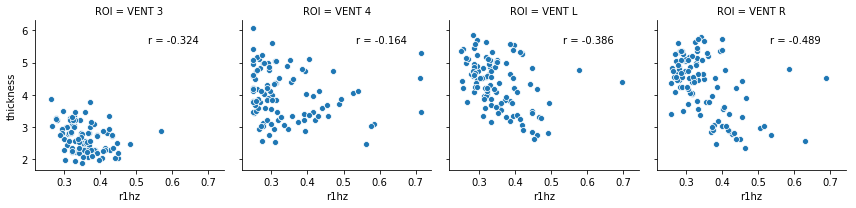

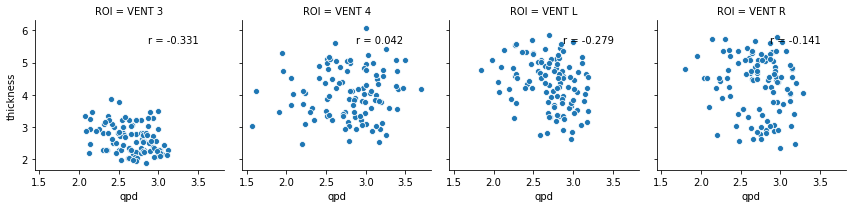

In [81]:
## Plot 
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPI': 'GM',
                                                    'GPE': 'GM',
                                                    'THA': 'GM',
                                                    'VENT': 'CSF',
                                                    'AMG': 'GM',
                                                    'IC': 'WM',
                                                    'VTA': 'GM',
                                                    'FX': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['r1hz', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()

# plot
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'r1hz', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)
    
# qpd
tmp = ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'].isin(['qpd', 'thickness'])) & (ahead_long['ROI2'] == 'VENT')]
tmp = tmp.pivot_table(values='Value', columns='Intensity', index=['Segmentation', 'ROI']).reset_index()    
fac = sns.FacetGrid(tmp, row=None, col='ROI')
fac.map(sns.scatterplot, 'qpd', 'thickness')

corcoefs = [tmp.loc[tmp['ROI'] == x].corr().iloc[0,1] for x in ['VENT 3', 'VENT 4', 'VENT L', 'VENT R']]

for ax, cor in zip(fac.axes.flat, corcoefs):
    ax.text(.6, 0.85, 'r = '+str(np.round(cor, 3)), transform=ax.transAxes)

In [50]:
## merge with cortical data, save
data = pd.merge(data, cortical_wide, how='outer')
col_names += ['Cerebellum', 'Cortex L', 'Cortex R']

# correct qpd
qpd_idx = data['Intensity'] == 'qpd'
def mean_notnull(x):
    return x[x>0].mean()

## Correct QPD by referencing to (mean across ventricles) ventricle-value
mean_qpd = data.loc[qpd_idx][['VENT R', 'VENT L', 'VENT 3', 'VENT 4']].apply(mean_notnull, 1)
data.loc[qpd_idx, col_names] /= np.tile(mean_qpd[:,np.newaxis], (1, len(col_names)))
data.loc[(qpd_idx)]

data.head()
data.to_csv('./AHEAD_and_CRUISE-wide-combined-qpdcorrected-icvcorrected-sexcorrected-thicknesscorrected.csv')

In [370]:
## Plot 
# Cast all columns except Measure, Intensity, Segmentation to float
structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)
    
# Melt
ahead_long = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe'],
                        value_vars=structs, value_name='Value', var_name='ROI')
ahead_long['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])
ahead_long['hemisphere'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_long['tissue_type'] = ahead_long['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPI': 'GM',
                                                    'GPE': 'GM',
                                                    'THA': 'GM',
                                                    'VENT': 'CSF',
                                                    'AMG': 'GM',
                                                    'IC': 'WM',
                                                    'VTA': 'GM',
                                                    'FX': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})
ahead_long.head()

Intensity        Measure Segmentation   Age Sexe    ROI      Value ROI2  \
0        qpd  IQR_intensity      sub-000  22.0    f  STR L   0.913435  STR   
1        qsm  IQR_intensity      sub-000  22.0    f  STR L   0.026822  STR   
2       r1hz  IQR_intensity      sub-000  22.0    f  STR L   0.078665  STR   
3       r2hz  IQR_intensity      sub-000  22.0    f  STR L  11.956550  STR   
4  thickness  IQR_intensity      sub-000  22.0    f  STR L   3.998104  STR   

  hemisphere tissue_type  
0          L          GM  
1          L          GM  
2          L          GM  
3          L          GM  
4          L          GM

In [306]:
## Restructure
ahead_wide = ahead_long.pivot_table(values='Value', index=['Segmentation', 'Measure', 'Age', 'Sexe', 'ROI', 'ROI2', 'hemisphere', 'tissue_type'], columns='Intensity')
ahead_wide.reset_index()

Intensity Segmentation         Measure   Age Sexe     ROI  ROI2 hemisphere  \
0              sub-000   IQR_intensity  22.0    f   AMG L   AMG          L   
1              sub-000   IQR_intensity  22.0    f   AMG R   AMG          R   
2              sub-000   IQR_intensity  22.0    f    CL L    CL          L   
3              sub-000   IQR_intensity  22.0    f    CL R    CL          R   
4              sub-000   IQR_intensity  22.0    f      FX    FX          X   
...                ...             ...   ...  ...     ...   ...        ...   
26034          sub-109  rSNR_intensity  23.0    f  VENT 4  VENT          4   
26035          sub-109  rSNR_intensity  23.0    f  VENT L  VENT          L   
26036          sub-109  rSNR_intensity  23.0    f  VENT R  VENT          R   
26037          sub-109  rSNR_intensity  23.0    f   VTA L   VTA          L   
26038          sub-109  rSNR_intensity  23.0    f   VTA R   VTA          R   

Intensity tissue_type        qpd       qsm      r1hz       r2hz  seg  \
0                  GM   0.130091  0.020086  0.042787   6.095428  NaN   
1                  GM   0.119831  0.020457  0.063154   6.279749  NaN   
2                  GM   0.133566  0.012567  0.080327   5.057586  NaN   
3                  GM   0.169598  0.013108  0.096512   4.259291  NaN   
4                  WM   0.251720  0.037315  0.250537  11.792614  NaN   
...               ...        ...       ...       ...        ...  ...   
26034             CSF  15.081038  0.471000  8.760983   0.314985  NaN   
26035             CSF   9.364481  0.444409  2.075376   0.490614  NaN   
26036             CSF   9.098735  0.430051  4.696347   0.317904  NaN   
26037              GM   7.350577 -0.506673  8.941840   4.558649  NaN   
26038              GM  14.611230 -0.296959  8.448158   4.342723  NaN   

Intensity  thickness  
0           3.508986  
1           3.742885  
2           0.629818  
3           1.189013  
4           1.738457  
...              ...  
26034            NaN  
26035            NaN  
26036            NaN  
26037            NaN  
26038            NaN  

[26039 rows x 14 columns]

In [307]:
ahead_wide['iron'] = -65.723586 + 55.164466*ahead_wide['qpd'] + 62.230206*ahead_wide['qsm'] + 15.730639*ahead_wide['r1hz'] + 0.233909*ahead_wide['r2hz']
ahead_wide['myelin'] = 30.899821 + -35.124823*ahead_wide['qpd'] + 97.174053*ahead_wide['qsm'] + 28.565140*ahead_wide['r1hz'] + -0.214869*ahead_wide['r2hz']

In [309]:
ahead_long = ahead_wide.reset_index().melt(id_vars=['Measure', "Segmentation", 'Age', 'Sexe', 'ROI', 'ROI2', 'hemisphere'],
                                           value_vars=['iron', 'myelin', 'r1hz', 'r2hz', 'qsm', 'qpd', 'thickness'], value_name='Value', var_name='Intensity')
ahead_long

Measure Segmentation   Age Sexe     ROI  ROI2 hemisphere  \
0        IQR_intensity      sub-000  22.0    f   AMG L   AMG          L   
1        IQR_intensity      sub-000  22.0    f   AMG R   AMG          R   
2        IQR_intensity      sub-000  22.0    f    CL L    CL          L   
3        IQR_intensity      sub-000  22.0    f    CL R    CL          R   
4        IQR_intensity      sub-000  22.0    f      FX    FX          X   
...                ...          ...   ...  ...     ...   ...        ...   
182268  rSNR_intensity      sub-109  23.0    f  VENT 4  VENT          4   
182269  rSNR_intensity      sub-109  23.0    f  VENT L  VENT          L   
182270  rSNR_intensity      sub-109  23.0    f  VENT R  VENT          R   
182271  rSNR_intensity      sub-109  23.0    f   VTA L   VTA          L   
182272  rSNR_intensity      sub-109  23.0    f   VTA R   VTA          R   

        Intensity      Value  
0            iron -55.198376  
1            iron -55.377769  
2            iron -55.126816  
3            iron -53.037617  
4            iron -42.815973  
...           ...        ...  
182268  thickness        NaN  
182269  thickness        NaN  
182270  thickness        NaN  
182271  thickness        NaN  
182272  thickness        NaN  

[182273 rows x 9 columns]

In [310]:
ahead_long.loc[ahead_long['ROI'] == 'FX', 'hemisphere'] = 'L'
ahead_long.loc[ahead_long['ROI'] == 'Cerebellum', 'hemisphere'] = 'L'

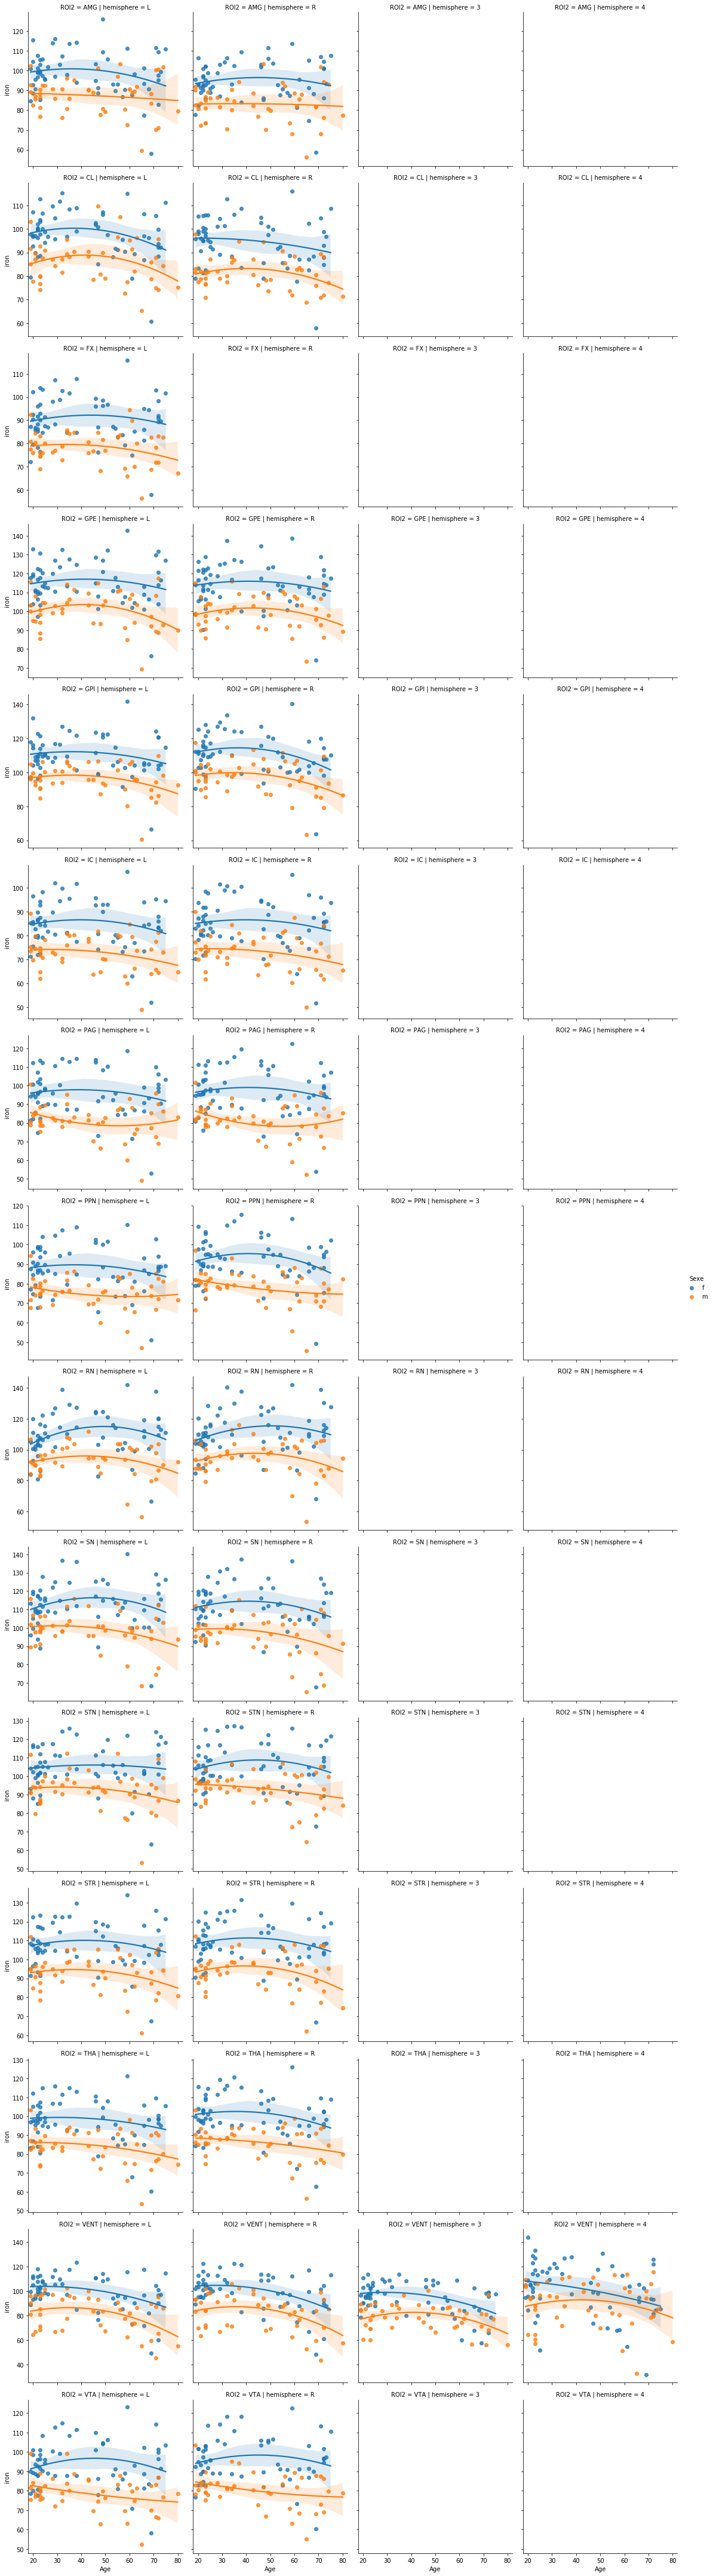

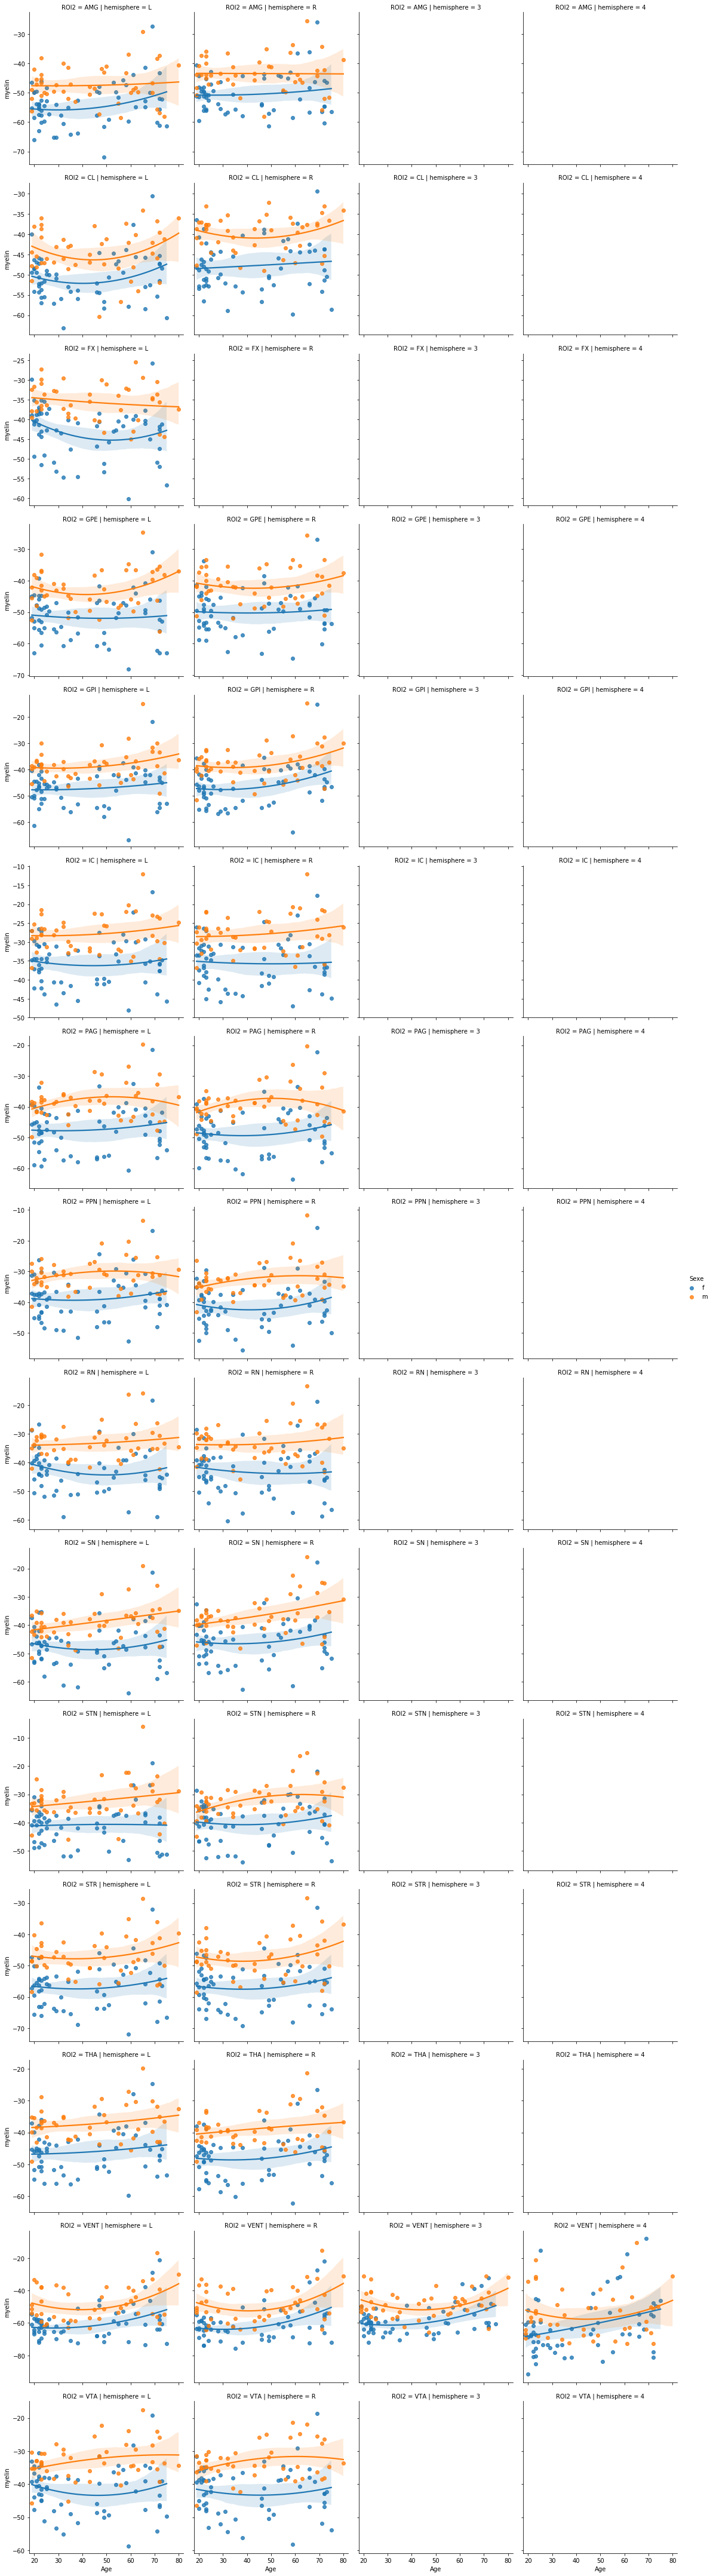

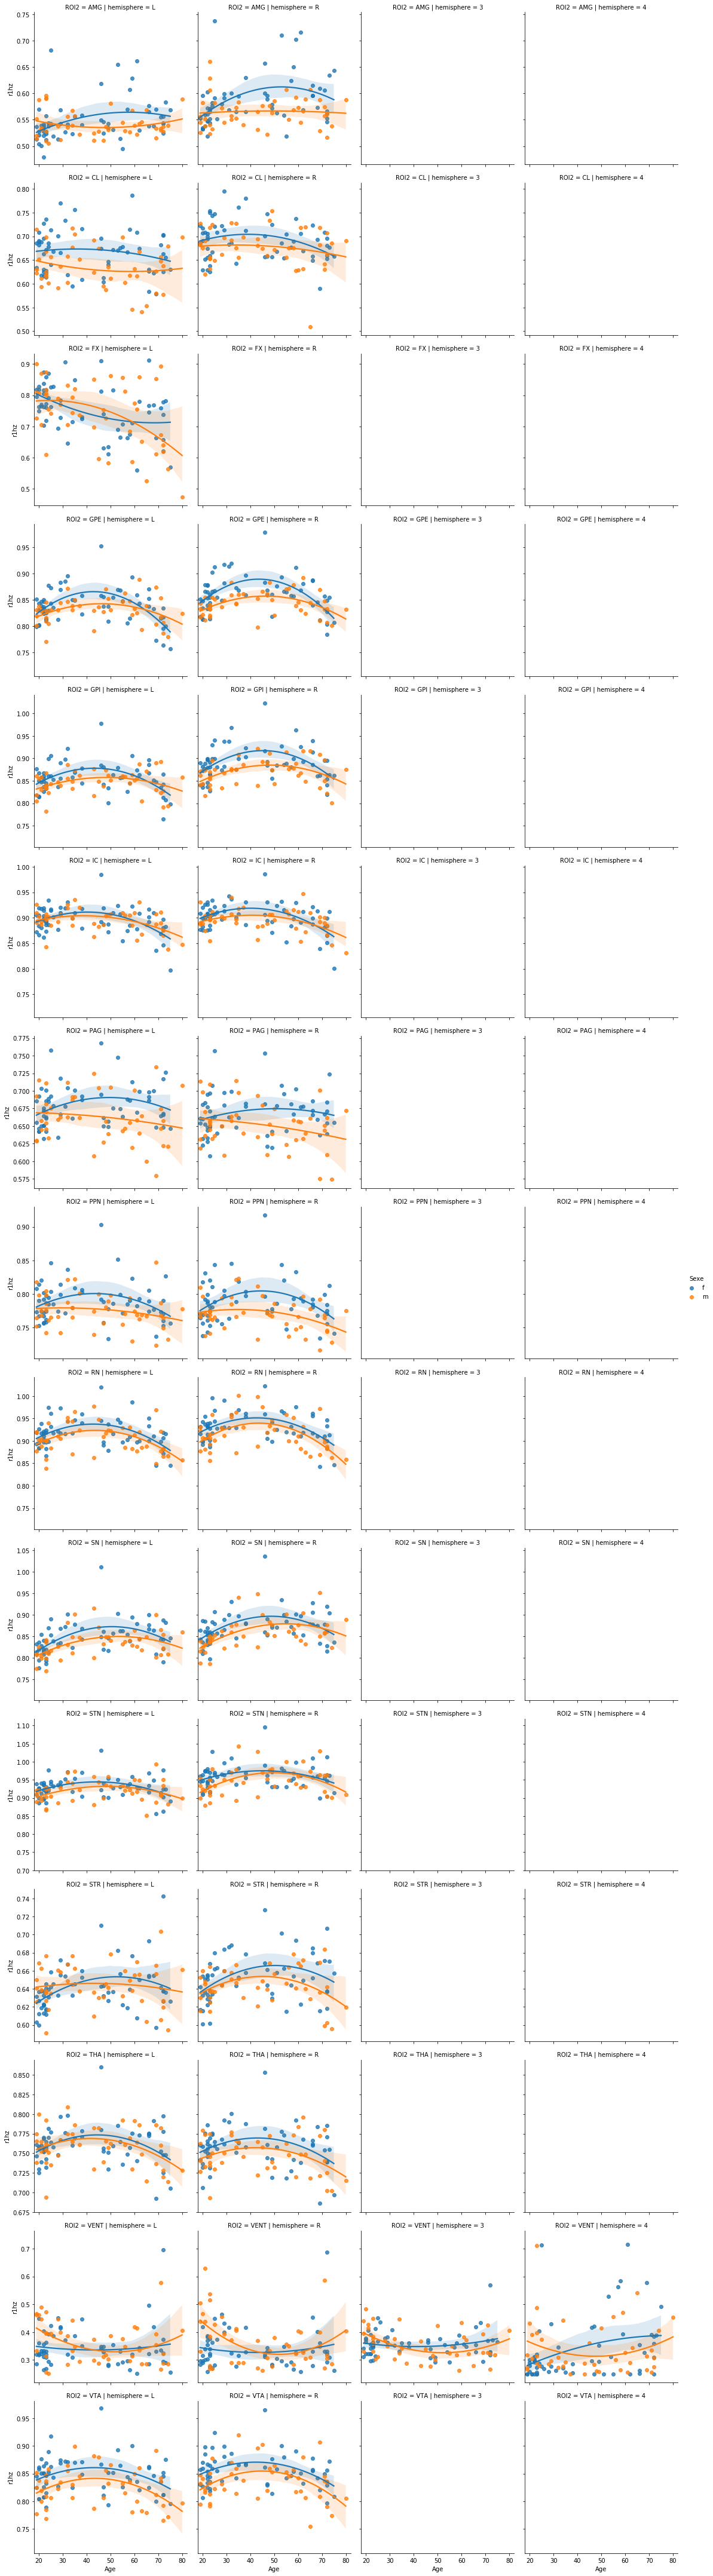

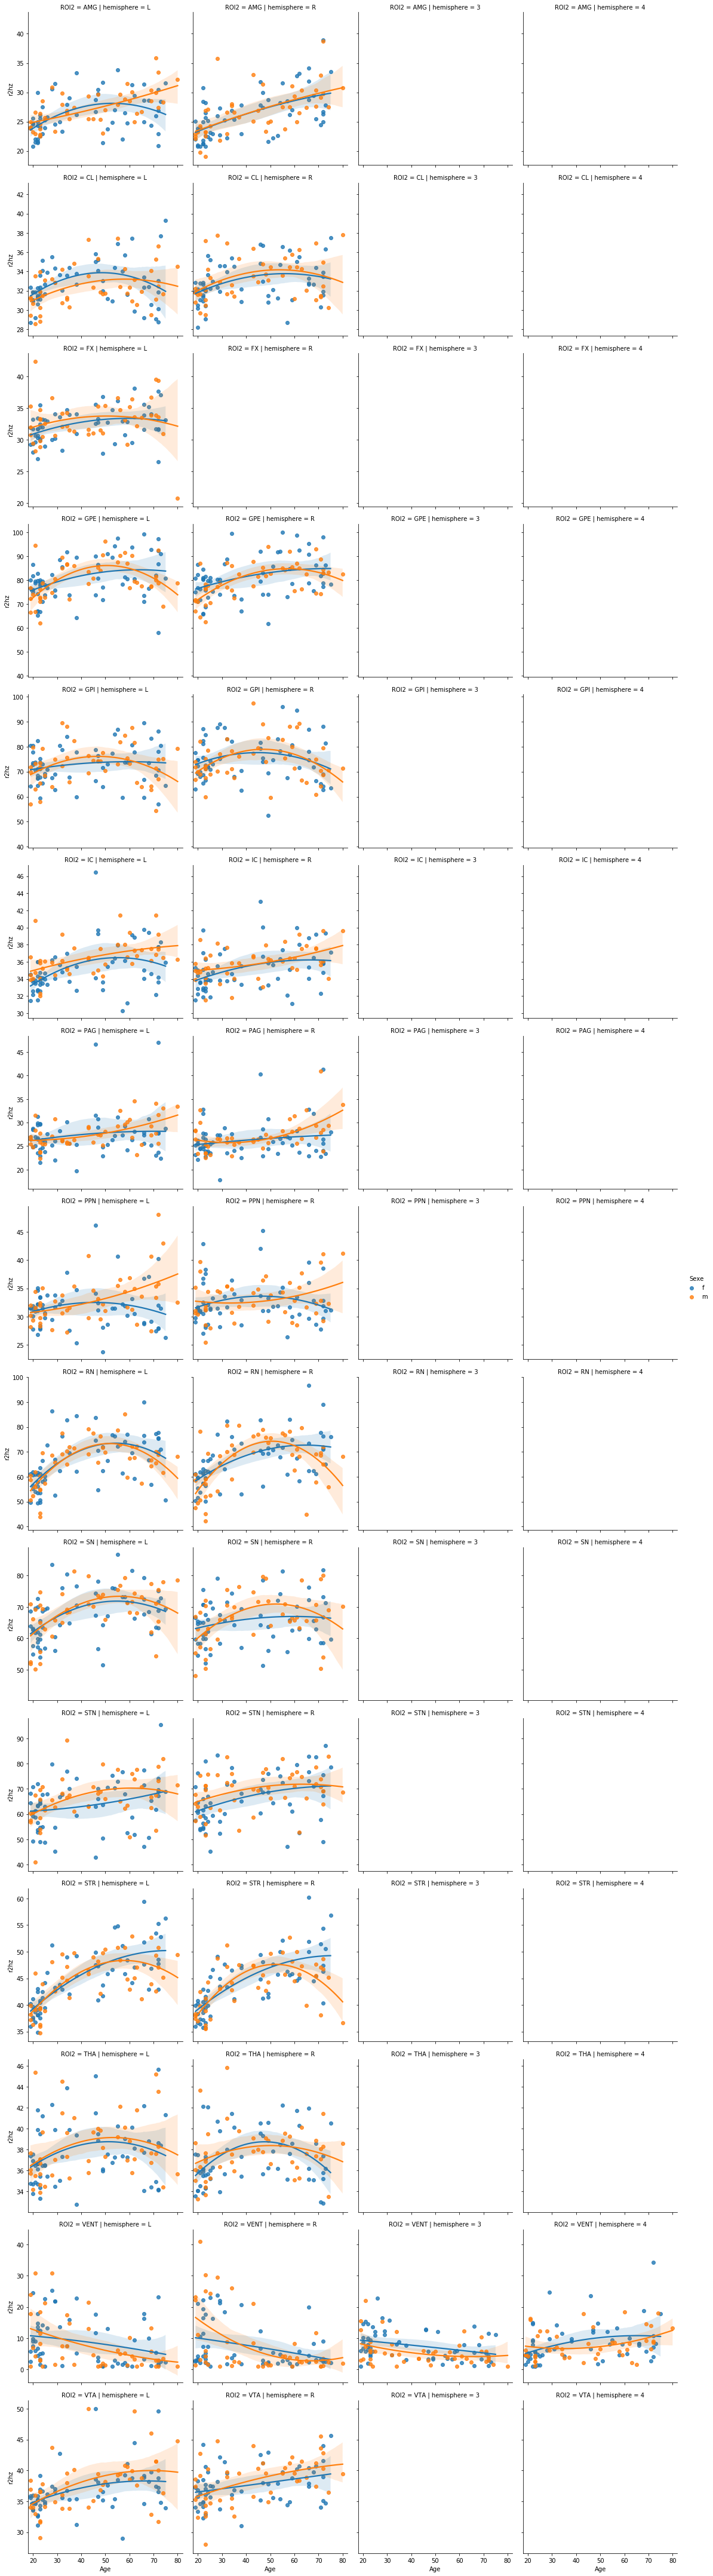

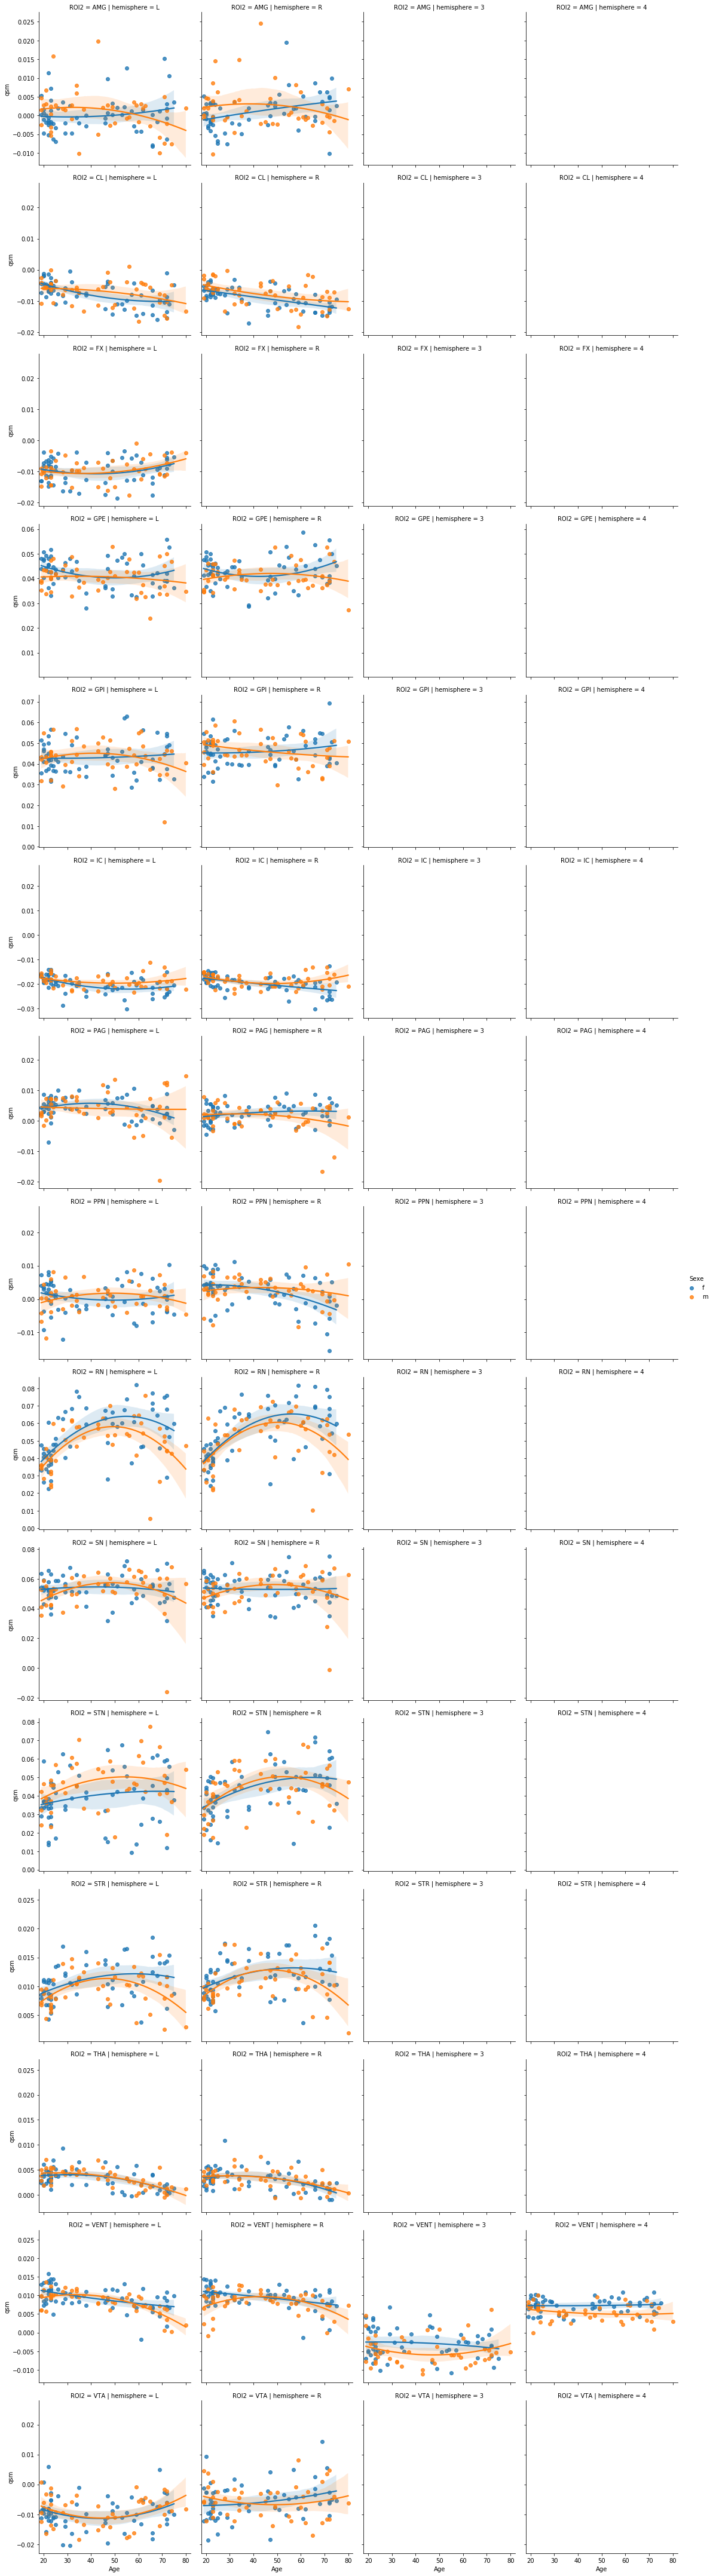

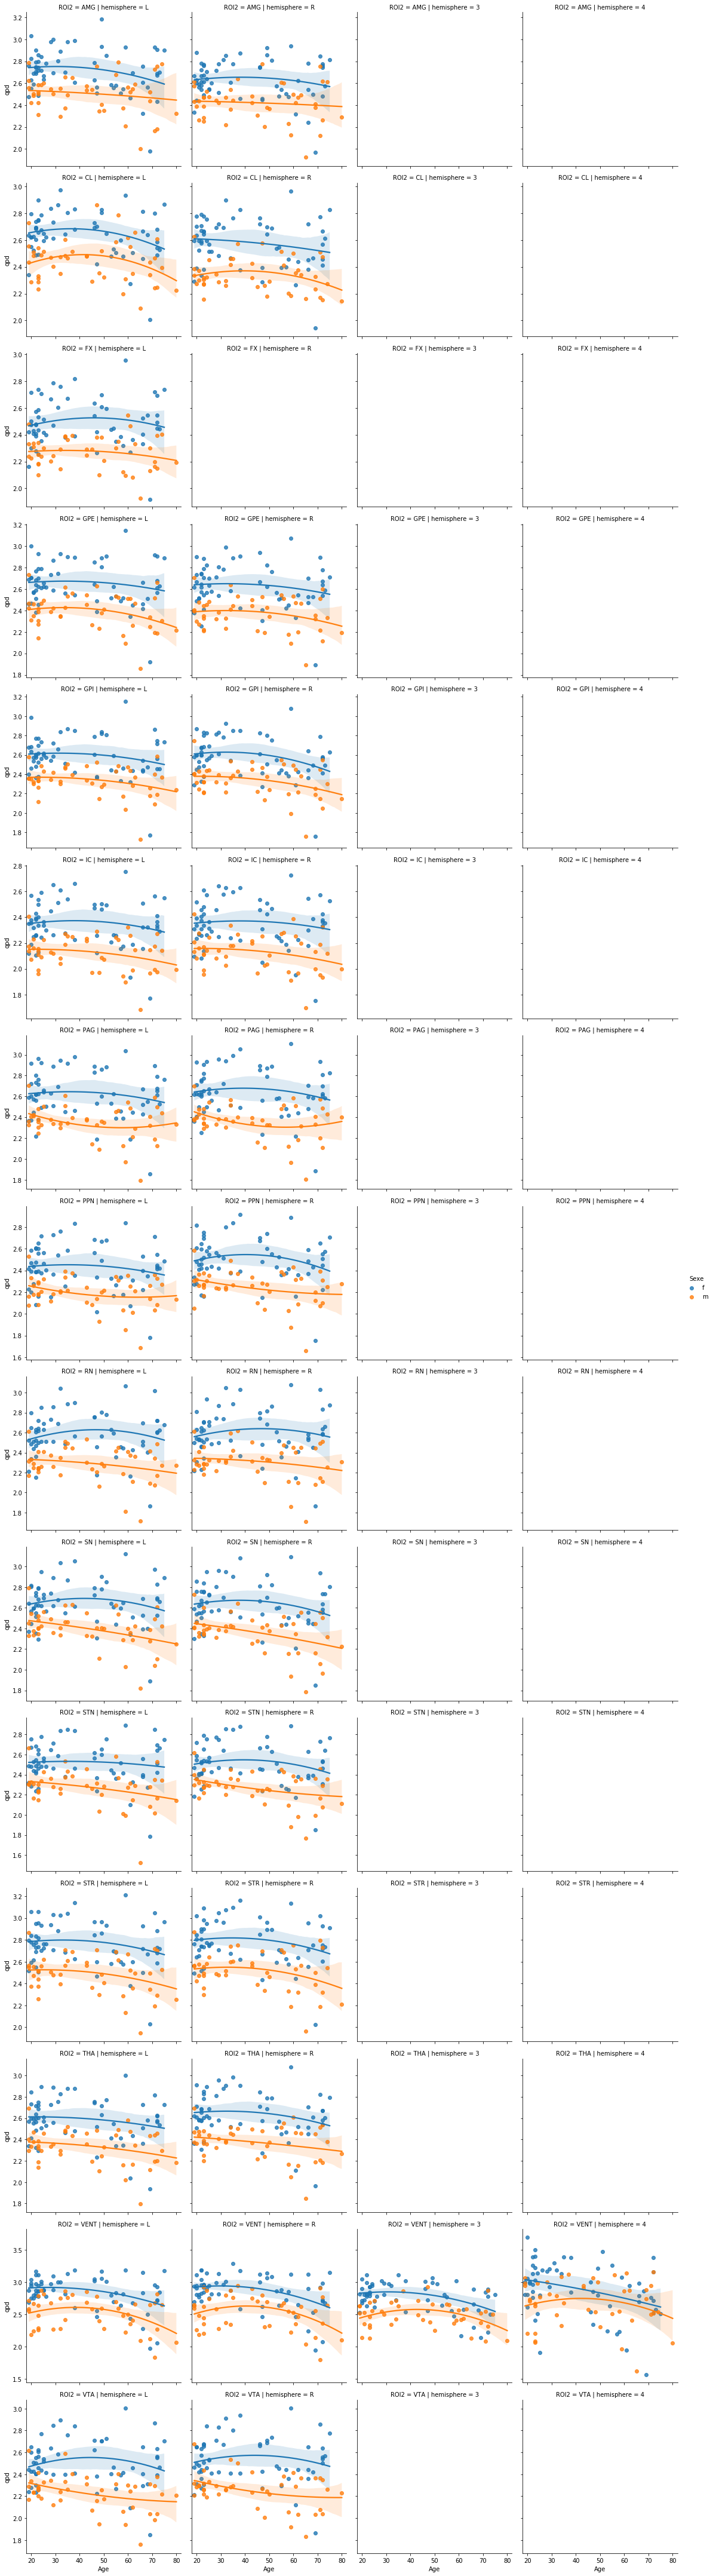

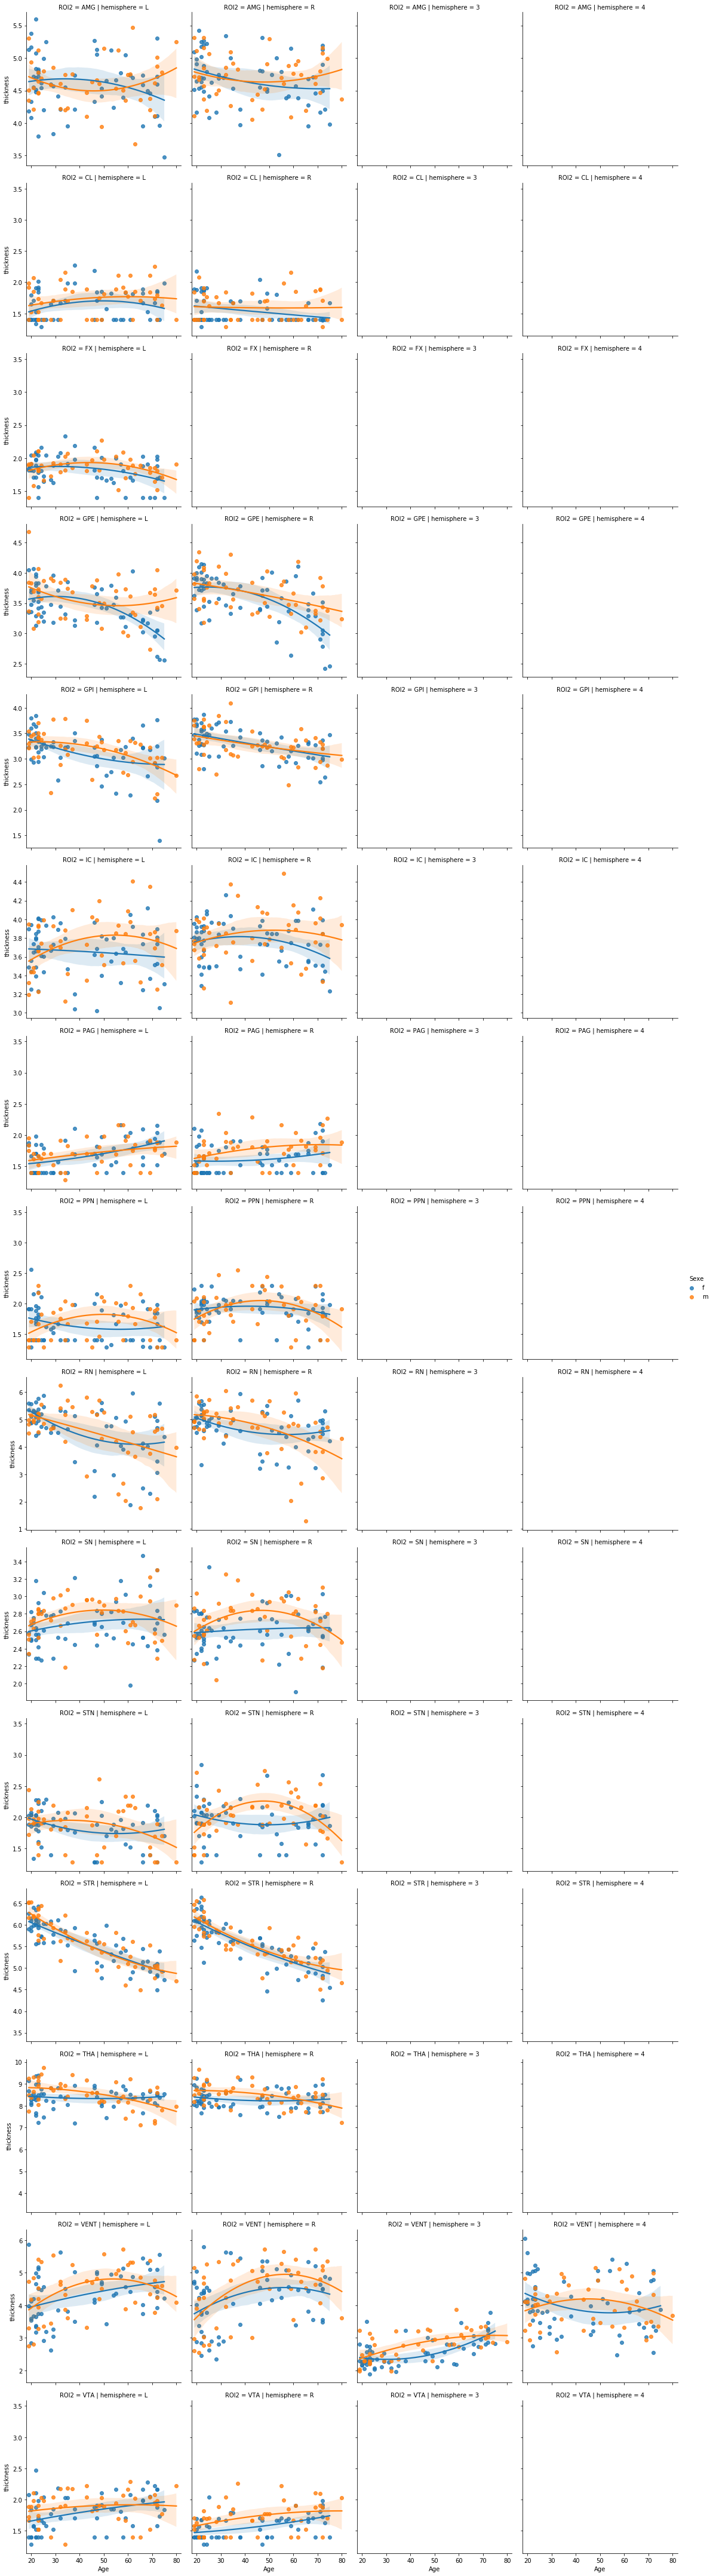

In [311]:
for modality in ahead_long.Intensity.unique():    
    fac = sns.lmplot(x='Age', y='Value', 
                     data=ahead_long.loc[(ahead_long['Measure'] == 'Median_intensity') & (ahead_long['Intensity'] == modality)], 
                     row='ROI2', col='hemisphere', height=4, 
                     aspect=1, sharey='row', hue='Sexe', order=2, truncate=True)
    fac.set(xlim=[18,82])§
    fac.set_ylabels(modality)

In [335]:
tmp

Measure Segmentation   Age Sexe     ROI  ROI2 hemisphere  \
52165   Median_intensity      sub-000  22.0    f  VENT 3  VENT          3   
52166   Median_intensity      sub-000  22.0    f  VENT 4  VENT          4   
52167   Median_intensity      sub-000  22.0    f  VENT L  VENT          L   
52168   Median_intensity      sub-000  22.0    f  VENT R  VENT          R   
52413   Median_intensity      sub-001  23.0    m  VENT 3  VENT          3   
...                  ...          ...   ...  ...     ...   ...        ...   
181867  Median_intensity      sub-108  23.0    m  VENT R  VENT          R   
182112  Median_intensity      sub-109  23.0    f  VENT 3  VENT          3   
182113  Median_intensity      sub-109  23.0    f  VENT 4  VENT          4   
182114  Median_intensity      sub-109  23.0    f  VENT L  VENT          L   
182115  Median_intensity      sub-109  23.0    f  VENT R  VENT          R   

        Intensity     Value  
52165        r1hz  0.296494  
52166        r1hz  0.293346  
52167        r1hz  0.263422  
52168        r1hz  0.258296  
52413        r1hz  0.331674  
...           ...       ...  
181867  thickness  4.228881  
182112  thickness  2.218564  
182113  thickness  5.225818  
182114  thickness  3.743737  
182115  thickness  4.399815  

[840 rows x 9 columns]

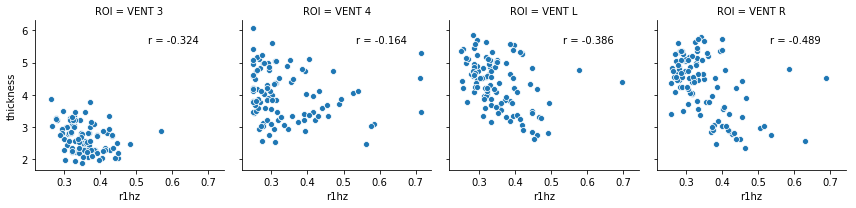

In [ ]:
## R

In [377]:
tmp = pd.concat([data.loc[(data['Intensity'] == 'thickness') & (data['Measure'] == 'Median_intensity'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']].reset_index(), 
                 data.loc[(data['Intensity'] == 'r1hz') & (data['Measure'] == 'Median_intensity'), ['VENT L', 'VENT R', 'VENT 3', 'VENT 4']].reset_index()], 1)

index    VENT L    VENT R    VENT 3    VENT 4  index    VENT L    VENT R  \
0       30  4.982990  4.363171  3.494426  2.741157     14  0.263422  0.258296   
1       62  3.951313  4.851950  2.227480  3.718653     46  0.313271  0.279858   
2       94  4.569306  4.447981  2.029468  3.465903     78  0.282777  0.281120   
3      126  4.875069  4.384382  2.728609  5.070369    110  0.330359  0.316112   
4      158  5.179710  5.796989  2.376548  4.173821    142  0.321083  0.339971   
..     ...       ...       ...       ...       ...    ...       ...       ...   
100   3230  2.627212  2.336565  2.110677  3.819660   3214  0.451901  0.463311   
101   3262  4.175396  3.908517  2.473992  4.111368   3246  0.462198  0.465605   
102   3294  3.280381  2.760638  2.193299  4.024887   3278  0.473273  0.536066   
103   3326  4.531384  4.228881  3.141327  4.208837   3310  0.396293  0.385173   
104   3358  3.743737  4.399815  2.218564  5.225818   3342  0.362494  0.321573   

       VENT 3    VENT 4  
0    0.296494  0.293346  
1    0.331674  0.487782  
2    0.450213  0.714188  
3    0.346069  0.250000  
4    0.355376  0.256757  
..        ...       ...  
100  0.378024  0.257656  
101  0.483033  0.432707  
102  0.448135  0.396535  
103  0.375715  0.287085  
104  0.362364  0.272594  

[105 rows x 10 columns]